# Академия Аналитиков Авито

# Эконометрика

# Домашняя работа №3

## №1 (40 баллов)

- Вам дан файлик `HW_003_001.csv`
- В нем находится одномерный временной ряд
- Ваша задача подобрать лучшую модель, которая бы описывала эти данные

- Начнем с чего-то простого. Загрузим данные

In [1]:
import pandas as pd

In [34]:
df = pd.read_csv('HW_003_001.csv')
df.head()

date         y
0  2018-07-18  0.101160
1  2018-07-19  0.622773
2  2018-07-20 -0.796028
3  2018-07-21  3.154209
4  2018-07-22  1.800747

- Нарисуем данные

In [3]:
import matplotlib.pyplot as plt

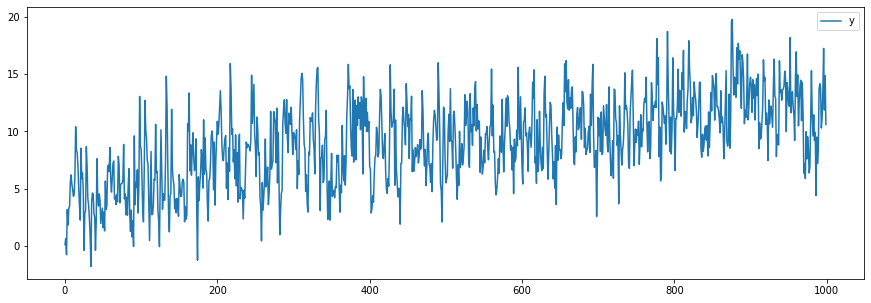

In [4]:
df.plot(figsize=(15, 5));

- Можно ли что-то сказать про данные судя по графику?

Видим, что этот временной ряд не стационарен. Явно заметен тренд к увеличению. Про сезонность сказать сложно, но скорее всего, она тоже имеется.

- Нарисуйте `ACF()`, `PACF()`

In [5]:
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf

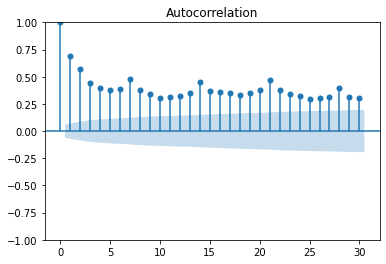

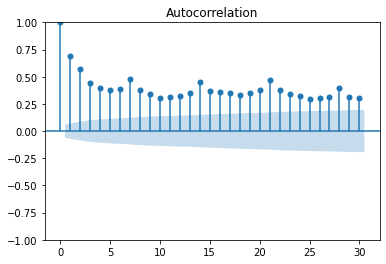

In [6]:
plot_acf(df['y'])

C:\Users\TEMP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


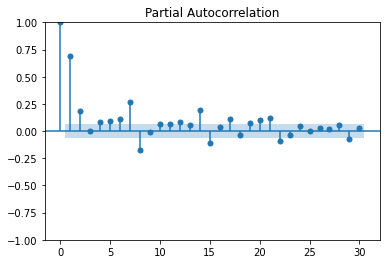

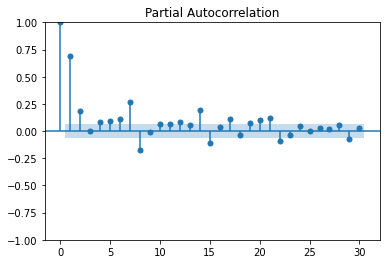

In [7]:
plot_pacf(df['y'])

- Можно ли сделать какой-то вывод?

Мы видим, что автокорреляция имеет место, наш процесс не стационарен. Исходя из паттерна графиков ACF, PACF можно предположить, что у нас AR-процесс (т.к. ACF плавно убывает, а PACF резко обрубается). Также заметно, что имеются характерные пики через каждые 7 дней, что может говорить о недельной сезональности.

- Ну а теперь ваша свобода 
- Продолжите анализ
    - Не забывайте про стационарность
    - А как насчет тренда?
    - Есть ли сезонность?
    - Может быть в [документации](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) будут еще полезные трюки
    - А может быть будет что-то полезное в [учебнике](https://otexts.com/fpp2/)

Проверим стационарность временного ряда с помощью стат. тестов:

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss, acf

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput, '\n Null Hypothesis: The series has a unit root.')
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output, '\n Null Hypothesis: The process is trend stationary.')

Сначала проведем тест Дики-Фуллера (тестрирует на нестационарность, вызванную сезональностью):

In [9]:
adf_test(df['y'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.657991
p-value                          0.081594
#Lags Used                      21.000000
Number of Observations Used    978.000000
Critical Value (1%)             -3.437054
Critical Value (5%)             -2.864500
Critical Value (10%)            -2.568346
dtype: float64 
 Null Hypothesis: The series has a unit root.


Таким образом, не отвергаем нулевую гипотезу о том, что ряд нестационарен => ряд нестационарен, выявлена сезональность.  

Теперь проведем KPSS-тест (тестирует на нестационарность, вызванную трендом):

In [10]:
kpss_test(df['y'])

Results of KPSS Test:
Test Statistic            4.263181
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64 
 Null Hypothesis: The process is trend stationary.


C:\Users\TEMP\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2012: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Таким образом, отвергаем нулевую гипотезу о стационарности => наш временной ряд нестационарен из-за влияния тренда.

In [11]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')# Чтобы не раздражали

Построим модель ARIMA и подберем оптимальные параметры:

In [12]:
n = 10
aic = pd.DataFrame(np.zeros((n, n)))
for p in range(n):
    for q in range(n):
        model = ARIMA(df.y, order=(p, 0, q), trend='ct', enforce_invertibility=False)
        res = model.fit()
        aic.iloc[p, q] = res.aic

In [13]:
aic

0            1            2            3            4  \
0  4999.563573  4793.558008  4702.406291  4693.465169  4678.764851   
1  4699.630035  4694.671506  4687.790149  4690.344159  4680.566986   
2  4692.195259  4703.543432  4689.503409  4691.600384  4647.856211   
3  4686.951574  4689.410292  4692.808964  4693.058907  4632.086756   
4  4688.937476  4691.284822  4693.178182  4695.392582  4657.561489   
5  4690.653205  4692.661597  4694.908069  4689.381338  4654.561798   
6  4690.243212  4694.649420  4669.563056  4727.520451  4645.979280   
7  4640.408196  4616.935375  4605.261783  4596.722339  4598.405315   
8  4594.132585  4595.393591  4596.289164  4657.585963  4596.306039   
9  4591.390178  4593.437262  4596.207253  4597.653248  4596.813263   

             5            6            7            8            9  
0  4676.488831  4645.396469  4629.418824  4626.974760  4623.800713  
1  4674.182890  4643.891624  4626.987231  4629.630236  4624.014464  
2  4656.228529  4649.091679  4630.365135  4630.809835  4625.672351  
3  4652.893143  4645.200186  4626.655485  4629.475214  4626.736240  
4  4656.610065  4636.388778  4625.334966  4618.570950  4626.874238  
5  4653.340041  4613.315088  4624.528849  4613.747233  4620.965569  
6  4654.680952  4649.479347  4626.101672  4612.676926  4582.227915  
7  4596.573057  4503.329181  4531.930046  4495.326846  4492.585795  
8  4583.418820  4501.533479  4634.077783  4491.141242  4600.774144  
9  4621.257533  4602.338700  4489.490482  4594.742855  4621.657065

In [14]:
aic.min(axis=0).min()

4489.4904822660465

In [35]:
df

date          y
0    2018-07-18   0.101160
1    2018-07-19   0.622773
2    2018-07-20  -0.796028
3    2018-07-21   3.154209
4    2018-07-22   1.800747
..          ...        ...
995  2021-04-08  13.486392
996  2021-04-09  17.259072
997  2021-04-10  11.866829
998  2021-04-11  14.866010
999  2021-04-12  10.596489

[1000 rows x 2 columns]

Таким образом, лучшая ARIMA модель дает следующие результаты:

In [36]:
best_arima = ARIMA(df.y, order=(9, 0, 7), trend='ct', enforce_invertibility=False)
best_arima = best_arima.fit()
best_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(9, 0, 7)   Log Likelihood               -2225.745
Date:                Sat, 01 Oct 2022   AIC                           4489.490
Time:                        15:43:01   BIC                           4582.738
Sample:                             0   HQIC                          4524.931
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1856      0.260     19.942      0.000       4.676       5.695
x1             0.0078      0.001     13.151      0.000       0.007       0.009
ar.L1          0.4392      0.059      7.457      0.000       0.324       0.555
ar.L2          0.2420      0.062      3.928      0.000       0.121       0.363
ar.L3          0.0164      0.028      0.585      0.558      -0.038       0.071
ar.L4          0.0046      0.032      0.143      0.886      -0.059       0.068
ar.L5          0.0209      0.029      0.712      0.477      -0.037       0.079
ar.L6         -0.0341      0.032     -1.075      0.282      -0.096       0.028
ar.L7          0.9028      0.030     29.881      0.000       0.844       0.962
ar.L8         -0.4238      0.046     -9.169      0.000      -0.514      -0.333
ar.L9         -0.1831      0.039     -4.658      0.000      -0.260      -0.106
ma.L1          0.0931      0.070      1.323      0.186      -0.045       0.231
ma.L2         -0.0524      0.069     -0.763      0.446      -0.187       0.082
ma.L3         -0.0805      0.060     -1.334      0.182      -0.199       0.038
ma.L4         -0.0754      0.059     -1.289      0.198      -0.190       0.039
ma.L5         -0.1062      0.059     -1.815      0.070      -0.221       0.008
ma.L6         -0.0128      0.061     -0.210      0.834      -0.132       0.107
ma.L7         -0.7630      0.058    -13.166      0.000      -0.877      -0.649
sigma2         5.0931      0.305     16.698      0.000       4.495       5.691
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.88   Prob(JB):                         0.80
Heteroskedasticity (H):               0.89   Skew:                             0.05
Prob(H) (two-sided):                  0.30   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Теперь снова посмотрим на стационарность (удалось ли ее добиться).   
Для этого построим сначала график остатков:

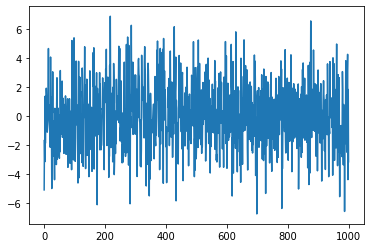

In [43]:
best_arima.resid.plot();

Видим, что это, действительно, похоже на белый шум. 
Снова построим ACF и PACF графики:

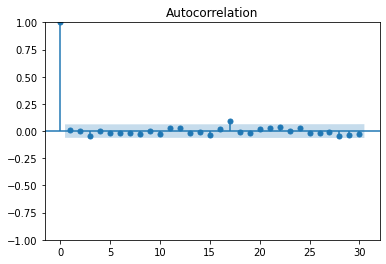

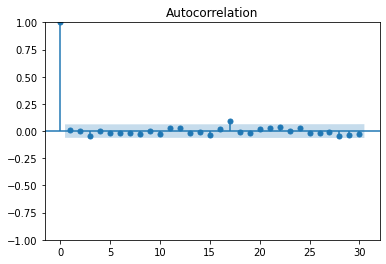

In [38]:
plot_acf(best_arima.resid)

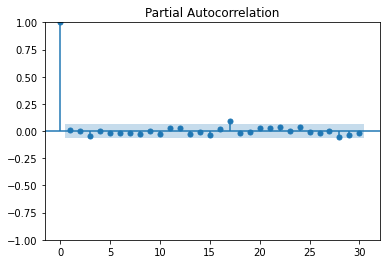

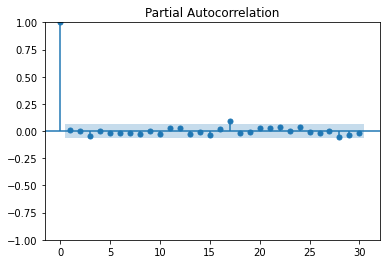

In [39]:
plot_pacf(best_arima.resid)

Построенные картинки говорят о том, что нам удалось избавиться от автокорреляции.  
Проведем также и статистические тесты:

In [40]:
adf_test(best_arima.resid)

Results of Dickey-Fuller Test:
Test Statistic                 -31.453929
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64 
 Null Hypothesis: The series has a unit root.


Таким образом, отвергаем нулевую гипотезу о том, что ряд нестационарен => ряд стационарен, сезональность устранена.  

In [41]:
kpss_test(best_arima.resid)

Results of KPSS Test:
Test Statistic           0.20241
p-value                  0.10000
Lags Used                5.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64 
 Null Hypothesis: The process is trend stationary.


Таким образом, не отвергаем нулевую гипотезу о стационарности => наш временной ряд стационарен, влияние тренда устранено.

**Далее будет две задачи. Вам надо выбрать одну. Если вы сделаете и 2.1, и 2.2, то будет выбран минимальный балл из двух**

## №2.1 (60 баллов)

- Не буду расписывать задание (как самый настоящий менеджер)
- На занятии вы разбирали данные о продажах Walmart для прогнозирования ежедневных продаж на следующие 28 дней. С кейсом можно озанкомиться на kaggle: [M5 Forecasting - Uncertainty](https://www.kaggle.com/c/m5-forecasting-uncertainty/overview). Продолжим с ними работать.
- Вам необходимо сделать модель предсказания продаж в штате Висконсин (WI) категории Hobbies в целом (не углубляясь до торговых точек)
- Данные берем [отсюда](https://www.kaggle.com/c/m5-forecasting-uncertainty/data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import prophet as fp 
import datetime
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

# инициализируем plotly
init_notebook_mode(connected = True)

In [178]:
# опишем функцию, которая будет визуализировать все колонки dataframe в виде line plot
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title, template='plotly_white')
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
# Функция для получения данных 'mdape', 'coverage' для модели по методу имитированных исторических прогнозов
def perf_metrics_28d(model):
    df_cv = cross_validation(model, initial='730.25 days', period='28 days', horizon = '28 days', \
                             parallel= 'processes')
    res = performance_metrics(df_cv,rolling_window = 1)
    return res[['smape','mdape', 'coverage']]

In [50]:
# Получение и обработка исходных данных. Источник - https://www.kaggle.com/c/m5-forecasting-uncertainty/data

# Тренировочный датафрейм с проданными айтемами
sales_train_validation = pd.read_csv('sales_train_validation.csv')

# Будем работать не с каждой конкретной точкой, а с продажами в каждом конкретном штате по категориям
stv_cols = [c for c in sales_train_validation.columns if c not in ['id','item_id','dept_id','store_id']]
sales_train_validation = sales_train_validation[stv_cols].groupby(['cat_id','state_id'], as_index = False).sum()

In [51]:
sales_train_validation

cat_id state_id    d_1   d_2   d_3   d_4   d_5   d_6   d_7    d_8  ...  \
0      FOODS       CA  10101  9862  6944  7864  7178  8256  9005  11870  ...   
1      FOODS       TX   6853  7030  5124  5470  4602  7067  4671   7055  ...   
2      FOODS       WI   6224  5866  5106  5544  2823  6770  6814   8826  ...   
3    HOBBIES       CA   1802  1561  1472  1405  1181  1459  1314   1986  ...   
4    HOBBIES       TX    879   870   526   809   501   831   390    785  ...   
5    HOBBIES       WI   1083   926   684   455   132   930  1240   1215  ...   
6  HOUSEHOLD       CA   2292  2382  1692  1778  1566  1607  1932   2754  ...   
7  HOUSEHOLD       TX   1706  1730  1128  1102   809  1108  1165   1600  ...   
8  HOUSEHOLD       WI   1691  1522  1107   985   354  1183  1479   1841  ...   

   d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  d_1910  d_1911  d_1912  \
0   10732   13094   14855   11217   10088    9863    9479   10991   13845   
1    6994    7944    8717    6834    7066    6242    6167    6839    7849   
2   10956   10969   10925    8100    7794    7527    7671    8874   10233   
3    1658    2176    2330    1706    1849    1646    1590    2015    2367   
4    1107    1124    1461     830    1025     980     882    1056    1222   
5    1021    1334    1029     787     913     846     881    1014    1198   
6    3865    5294    5847    4129    3847    3639    3419    4089    5622   
7    2699    3392    3531    2204    2831    2378    2553    2720    3195   
8    2757    3035    2945    2252    2157    2222    2391    2919    3431   

   d_1913  
0   14806  
1    7765  
2   10083  
3    2357  
4    1266  
5    1060  
6    6024  
7    3251  
8    3183  

[9 rows x 1915 columns]

In [52]:
# Cправочник дат. SNAP - индикатор участия магазина в программе льготной покупки продуктов (Supplemental Nutrition Assistance Program)
calendar = pd.read_csv('calendar.csv', parse_dates = ['date'])
calendar['date'] = calendar.date.dt.date
calendar = calendar[['date', 'd', 'event_name_1','event_type_1','event_name_2','event_type_2', \
                     'snap_CA', 'snap_TX', 'snap_WI']]

# Преобразуем данные в удобный формат
stv_cols_tr = [c for c in stv_cols if c not in ['cat_id','state_id']]
sales_train_validation = pd.melt(sales_train_validation, id_vars = ['cat_id','state_id'], \
                                value_vars = stv_cols_tr)
# Присоединение дат к id
sales_train_validation.columns = ['cat_id', 'state_id', 'd', 'y']
sales_train_validation = sales_train_validation.merge(calendar[['d', 'date']], how = 'left', on = 'd')

In [53]:
sales_train_validation

cat_id state_id       d      y        date
0          FOODS       CA     d_1  10101  2011-01-29
1          FOODS       TX     d_1   6853  2011-01-29
2          FOODS       WI     d_1   6224  2011-01-29
3        HOBBIES       CA     d_1   1802  2011-01-29
4        HOBBIES       TX     d_1    879  2011-01-29
...          ...      ...     ...    ...         ...
17212    HOBBIES       TX  d_1913   1266  2016-04-24
17213    HOBBIES       WI  d_1913   1060  2016-04-24
17214  HOUSEHOLD       CA  d_1913   6024  2016-04-24
17215  HOUSEHOLD       TX  d_1913   3251  2016-04-24
17216  HOUSEHOLD       WI  d_1913   3183  2016-04-24

[17217 rows x 5 columns]

In [54]:
# Приведение к нужному для fbtophet виду
sales_train_validation = sales_train_validation[['date', 'state_id', 'cat_id', 'y']]
sales_train_validation.columns = ['ds', 'state_id', 'cat_id', 'y']

In [55]:
# Данные без 4 последних недель - на них будем подбирать параметры нашей модели
sales_train_validation.tail()

ds state_id     cat_id     y
17212  2016-04-24       TX    HOBBIES  1266
17213  2016-04-24       WI    HOBBIES  1060
17214  2016-04-24       CA  HOUSEHOLD  6024
17215  2016-04-24       TX  HOUSEHOLD  3251
17216  2016-04-24       WI  HOUSEHOLD  3183

In [56]:
# Проделаем аналогичные действия для проверочных данных 
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')
ste_cols = [c for c in sales_train_evaluation.columns if c not in ['id','item_id','dept_id','store_id']]
sales_train_evaluation = sales_train_evaluation[ste_cols].groupby(['cat_id','state_id'], as_index = False).sum()
ste_cols_tr = [c for c in ste_cols if c not in ['cat_id','state_id']]
sales_train_evaluation = pd.melt(sales_train_evaluation, id_vars = ['cat_id','state_id'], \
                                value_vars = ste_cols_tr)
sales_train_evaluation.columns = ['cat_id', 'state_id', 'd', 'y']
sales_train_evaluation = sales_train_evaluation.merge(calendar[['d', 'date']], how = 'left', on = 'd')
sales_train_evaluation = sales_train_evaluation[['date', 'state_id', 'cat_id', 'y']]
sales_train_evaluation.columns = ['ds', 'state_id', 'cat_id', 'y']

In [57]:
# Данные с 28 оставшимися днями - после подгонки модели проверим соответсвие качества на этом "кусочке"
sales_train_evaluation.tail()

ds state_id     cat_id     y
17464  2016-05-22       TX    HOBBIES  1543
17465  2016-05-22       WI    HOBBIES  1223
17466  2016-05-22       CA  HOUSEHOLD  6160
17467  2016-05-22       TX  HOUSEHOLD  3772
17468  2016-05-22       WI  HOUSEHOLD  3159

In [58]:
# Выделим только данные по Калифорнии
wi_data = sales_train_validation.loc[(sales_train_validation.state_id == 'WI') & 
                                     (sales_train_validation.cat_id == 'HOBBIES'), ['ds', 'cat_id', 'y']].copy()
wi_data_evaluation = sales_train_evaluation.loc[(sales_train_evaluation.cat_id == 'HOBBIES')&
                                             (sales_train_evaluation.state_id == 'WI'),
                                             ['ds', 'y']].copy().reset_index(drop = True)

# Посмотрим на распрделение продаж по категориям
plotly_df(wi_data.pivot(index='ds', columns='cat_id', values='y'), title = 'WI items sold (category HOBBIES)')

- Что можете сказать?  
    - Видим, что явной годовой сезональности не наблюдается, а вот недельная ярко выражена (если провалиться в график поглубже).
    - Тренд присутствует (с середины 2012 до 2013 - отрицательный, с конца 2014 до конца - положительный).
    - Видны ежегодные выбросы, которые соответсвуют 25 декабря (католическому Рождеству), когда магазины закрыты (продажи равны 0).
        - Все это говорит о том, что данный временной ряд не является стационарным (это важно при построении ARIMA).
        
Построим теперь базовую модель - Prophet с дефолтными параметрами:

### Базовая модель

In [59]:
# 1. Создадим объект класса Prophet (все параметры модели задаются в конструкторе класса, используем дефолтные)
m = fp.Prophet()

# 2. Проведем обучение
m.fit(wi_data)

# 3. Cоздадим таблицу с датами, охватывающими даты истории + "горизонт" для прогнозирования
future = m.make_future_dataframe(periods=28)

# 4. Получим предсказания на датах, полученных в предыдщуем шаге
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


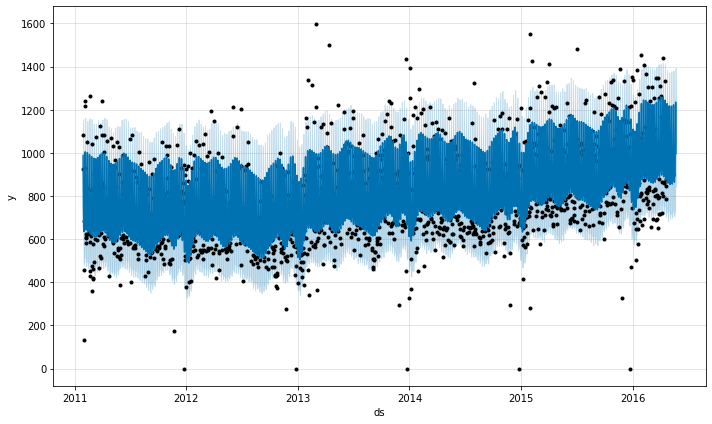

In [60]:
# Встроенный метод для отображения прогноза
# Отражается с 80% интервалом неопределенности (зависящий от тренда и шума)
fig1 = m.plot(forecast)

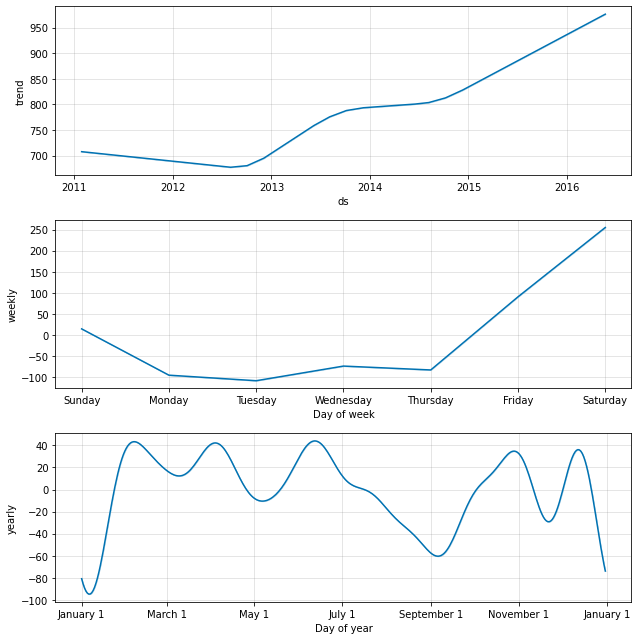

In [61]:
fig2 = m.plot_components(forecast)

In [95]:
pb_metrics = perf_metrics_28d(m)
print(f"Performance metrics:\nmdape = {round(pb_metrics.at[0,'mdape']*100,1)}%\ncoverage = {round(pb_metrics.at[0,'coverage']*100,1)}%\nsmape = {round(pb_metrics.at[0,'smape']*100,1)}%")

INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8192048>
INFO:prophet:Skipping MAPE because y close to 0


Performance metrics:
mdape = 9.8%
coverage = 81.5%
smape = 12.8%


- Что у вас получилось? 
- Что еще можете сказать, скажем, по поводу компонентов модели?


По графику с прогнозом видим, что модель довольно сильно ошибается (есть фактические точки, которые не накрываются даже доверительным интервалом прогноза, например рождественские дни, которые мы пока не учитываем), но в целом неплохо отражает имеющиеся данные.

По поводу компонентов можно сказать, что Prophet подтвердил результаты визуального анализа:
1. тренд изменяется примерно также, как говорилось;
2. наблюдается явная недельная сезональность (люди покупают чаще всего ближе к выходным, но в воскресенье активность падает до уровня середины недели);
3. по ежегодной сезональности можно видеть, что в январе и сентябре наблюдается явный спад продаж (с январем примерно ясно, но сентябрем для меня не очень понятно почему - видимо, все вкатываются в начало учебного года).
 
 
 

- На занятии вам показывали 100500 параметров, с которыми можно поиграться, чтобы получить "лучшую" модель
- Во-первых, начнем с последнего, какзалось бы, шага. Какую метрику вы будете использовать? Почему?
- Каким именно способом вы будете проводить диагностику модели и сравнивать модели?
- Какие параметры вы будете менять? Почему? Попробуйте предположить, как именно необходимо поменять параметр модели, прежде чем приступать к тестированию. За неверное предположение баллы сниматься не будут при наличии обоснования.
- Как еще можно улучшить модель? Что можно добавить еще?

1. Думаю, что логичнее всего использовать **SMAPE** (аналог MAPE, который устойчив к нулевым фактическим значениям, которые присутствуют у нас в рождественские дни) - так как это относительная метрика (абсолютная ошибка вряд ли бы сказала нам хорошее это значение или плохое). Можно было бы воспользоваться MDAPE, которая лечит от выбросов, но мы эти выбросы хотим учитывать - будет обидно, если это не отразится на итоговой метрике.
2. Для диагностики и сравнения моделей воспользуемся кросс-валидацией. Будем смотреть на метрику SMAPE (лучшая модель - это модель с наименьшим SMAPE).
3. 
    - Тренд ведет себя, как мне кажется, адекватно, но очень уж грубо => мб стоит только поднять число точек излома (**n_changepoints**) и чувствительность к их обнаружению (**changepoint_prior_scale**), чтобы он был более гибок.
    - Думаю, нужно добавить мультипликативный учет сезональности (**seasonality_mode**), так как глядя на исходный график временного ряда, видно, что "пики" меняют масштаб. Недельная сезональность выглядит адекватно, а годовая выглядит чересчур  "извилисто", мб стоит снизить **fourier_order**.
    - Ну, и точно следует добавить учет аномальных значений - таких как в Рождество (**holidays**).
4. Еще можно добавить новые регрессоры, которые помогут улучшить качество модели (например, периоды, в которые проводятся крупные акции на товары из категории HOBBIES или даты проведения творческих, спортивных мероприятий => скорее всего тогда будет больше покупок в нужной категории). 

Попробуем улучшить модель:

In [111]:
import holidays

us_ca_holidays = holidays.UnitedStates(state='CA', years = [2011,2012,2013,2014,2015,2016,2017,2018], \
                                       observed = False)

holiday_df = pd.DataFrame.from_dict(us_ca_holidays, orient='index').reset_index(drop = False)
holiday_df.columns = ['ds', 'holiday']
holiday_df = holiday_df.sort_values('ds').reset_index(drop = True)
holiday_df['lower_window'] = -1
holiday_df['upper_window'] = 1
holiday_df = holiday_df[['holiday', 'ds', 'lower_window', 'upper_window']]

# В данных calendar в качестве событий были отмечены Пасха и День отца
# Эти два регулярных события тоже могут отражаться на покупках (следует проверить данный факт отдельно)
# Но сейчас в рамках нашей задачи мы так же вынесем эти дни + Valentine's Day в датафрейм с праздниками
# В эти дни продажи отличаются от аналогичных обычных дней

custom_holidays = pd.DataFrame([{'holiday' : "Father's day", 'ds' : datetime.date(2011,6,19), \
                                 'lower_window':-2, 'upper_window':0},
 {'holiday' : "Father's day", 'ds' : datetime.date(2012,6,17), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2013,6,16), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2014,6,15), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2015,6,21), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2016,6,19), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2017,6,18), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2018,6,17), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2011,4,24), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2012,4,15), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2013,5,5), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2014,4,20), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2015,4,12), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2016,5,1), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2017,4,16), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2018,4,8), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2011,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2012,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2013,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2014,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2015,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2016,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2017,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2018,2,14), 'lower_window':-1, 'upper_window':1}])

holiday_df = pd.concat([holiday_df, custom_holidays])
holiday_df = holiday_df.sort_values('ds').reset_index(drop = True)
holiday_df.head()

holiday          ds  lower_window  upper_window
0              New Year's Day  2011-01-01            -1             1
1  Martin Luther King Jr. Day  2011-01-17            -1             1
2             Valentine's Day  2011-02-14            -1             1
3       Washington's Birthday  2011-02-21            -1             1
4            César Chávez Day  2011-03-31            -1             1

Переберем озвученные ранее параметры по сетке (grid search - **выполняется ооооооооочень долго**):

In [119]:
from tqdm import tqdm

changepoint_prior_scale = np.linspace(0.04, 0.2, 5)
n_changepoints = [20, 50, 80]
seasonality_mode = [0, 1]
fourier_order_yearly = [7, 10, 12]
fourier_order_weekly = [1, 3, 5]
holidays = [1]
holidays_prior_scale = [1, 5, 10]

best_smape = np.inf

for cps in tqdm(changepoint_prior_scale):
    for nc in tqdm(n_changepoints):
        for sm in tqdm(seasonality_mode):
            for foy in tqdm(fourier_order_yearly):
                for fow in tqdm(fourier_order_weekly):
                    for h in tqdm(holidays):
                        if h:
                            for hps in tqdm(holidays_prior_scale):
                                m_custom = fp.Prophet(
                                    changepoint_prior_scale = cps,
                                    n_changepoints = nc,
                                    seasonality_mode = 'multiplicative' if sm else 'additive',
                                    yearly_seasonality = foy,
                                    weekly_seasonality = fow,
                                    holidays = holiday_df,
                                    holidays_prior_scale = hps
                                )
                                m_custom.fit(wi_data)
                                metrics = perf_metrics_28d(m_custom)
                                params = [cps, nc, sm, foy, fow, h, hps]
                                print(f"smape={round(metrics.at[0,'smape']*100,1)}%, "
                                  f"mdape={round(metrics.at[0,'mdape']*100,1)}%, "
                                  f"coverage={round(metrics.at[0,'coverage']*100,1)}%, params={params}")
                                if metrics.at[0,'smape'] < best_smape:
                                    best_smape = metrics.at[0,'smape']
                        else:
                            m_custom = fp.Prophet(
                                changepoint_prior_scale = cps,
                                n_changepoints = nc,
                                seasonality_mode = 'multiplicative' if sm else 'additive',
                                yearly_seasonality = foy,
                                weekly_seasonality = fow,
                            )
                            m_custom.fit(wi_data)
                            metrics = perf_metrics_28d(m_custom)
                            params = [cps, nc, sm, foy, fow, h]
                            print(f"smape={round(metrics.at[0,'smape']*100,1)}%, "
                                  f"mdape={round(metrics.at[0,'mdape']*100,1)}%, "
                                  f"coverage={round(metrics.at[0,'coverage']*100,1)}%, params={params}")
                            if metrics.at[0,'smape'] < best_smape:
                                    best_smape = metrics.at[0,'smape']

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prop

smape=13.5%, mdape=10.3%, coverage=77.9%, params=[0.04, 20, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EE20C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:46<00:23, 23.49s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.3%, coverage=77.6%, params=[0.04, 20, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EC2E08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:08<00:00, 22.98s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:08<00:00, 68.96s/it]




 33%|████████████████████████████                                                        | 1/3 [01:08<02:17, 68.99s/it]

smape=13.5%, mdape=10.3%, coverage=77.3%, params=[0.04, 20, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8FE6588>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:24<00:48, 24.32s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.6%, params=[0.04, 20, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A89EBB08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:50<00:25, 25.39s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.7%, params=[0.04, 20, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DD8448>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:16<00:00, 25.65s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:16<00:00, 76.96s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [02:26<01:13, 73.73s/it]

smape=12.4%, mdape=9.4%, coverage=78.0%, params=[0.04, 20, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EBD7C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:24<00:48, 24.33s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.7%, params=[0.04, 20, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A883EDC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:49<00:24, 24.56s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.8%, params=[0.04, 20, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A5E75B08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:15<00:00, 25.05s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:15<00:00, 75.17s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:41<00:00, 73.75s/it]



 33%|███████████████████████████▋                                                       | 1/3 [03:41<07:22, 221.26s/it]

smape=12.4%, mdape=9.4%, coverage=78.4%, params=[0.04, 20, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA077648>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:25<00:51, 25.65s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.6%, mdape=10.3%, coverage=76.9%, params=[0.04, 20, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FAAD08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:53<00:26, 26.86s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.6%, mdape=10.3%, coverage=77.6%, params=[0.04, 20, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7FA23C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:19<00:00, 26.54s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:19<00:00, 79.67s/it]




 33%|████████████████████████████                                                        | 1/3 [01:19<02:39, 79.71s/it]

smape=13.6%, mdape=10.4%, coverage=78.1%, params=[0.04, 20, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8339908>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:27<00:55, 27.67s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.6%, coverage=77.6%, params=[0.04, 20, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FCE348>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:58<00:29, 29.60s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=78.0%, params=[0.04, 20, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A799B408>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:27<00:00, 29.06s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:27<00:00, 87.23s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [02:46<01:24, 84.15s/it]

smape=12.5%, mdape=9.5%, coverage=77.6%, params=[0.04, 20, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A89C3C88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:31<01:02, 31.19s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=78.0%, params=[0.04, 20, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7597088>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:08<00:34, 34.66s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=77.7%, params=[0.04, 20, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EC9808>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:41<00:00, 33.76s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:41<00:00, 101.34s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:28<00:00, 89.44s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [08:09<04:08, 248.97s/it]

smape=12.5%, mdape=9.5%, coverage=77.9%, params=[0.04, 20, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7327F88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:29<00:59, 29.69s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.6%, mdape=10.5%, coverage=77.2%, params=[0.04, 20, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A846CA08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:00<00:30, 30.46s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.4%, coverage=77.2%, params=[0.04, 20, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A746E0C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:33<00:00, 31.15s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:33<00:00, 93.50s/it]




 33%|████████████████████████████                                                        | 1/3 [01:33<03:07, 93.53s/it]

smape=13.6%, mdape=10.4%, coverage=77.4%, params=[0.04, 20, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A735BC48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:31<01:02, 31.48s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=77.6%, params=[0.04, 20, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7A36408>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:08<00:34, 34.76s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.6%, mdape=9.5%, coverage=77.7%, params=[0.04, 20, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83335C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:37<00:00, 32.58s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:37<00:00, 97.82s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [03:11<01:36, 96.10s/it]

smape=12.5%, mdape=9.5%, coverage=78.0%, params=[0.04, 20, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7BB688>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:29<00:59, 29.52s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=77.6%, params=[0.04, 20, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7E43E08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:58<00:29, 29.30s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=76.9%, params=[0.04, 20, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8A1E888>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:30<00:00, 30.15s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:30<00:00, 90.50s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:41<00:00, 93.99s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [12:51<00:00, 257.23s/it]


 50%|█████████████████████████████████████████▌                                         | 1/2 [12:51<12:51, 771.68s/it]

smape=12.6%, mdape=9.4%, coverage=77.7%, params=[0.04, 20, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7D46948>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.4%, mdape=10.4%, coverage=78.1%, params=[0.04, 20, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7463108>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:49<00:24, 24.74s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.4%, coverage=77.2%, params=[0.04, 20, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC3D8C88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:20<00:00, 26.86s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:20<00:00, 80.61s/it]




 33%|████████████████████████████                                                        | 1/3 [01:20<02:41, 80.64s/it]

smape=13.5%, mdape=10.4%, coverage=77.6%, params=[0.04, 20, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7E431C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:27<00:55, 27.81s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.1%, coverage=77.0%, params=[0.04, 20, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F59F48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:55<00:27, 27.73s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=77.6%, params=[0.04, 20, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F816C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:22<00:00, 27.56s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:22<00:00, 82.73s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [02:43<01:21, 81.88s/it]

smape=12.4%, mdape=9.2%, coverage=76.6%, params=[0.04, 20, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A72FA088>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:31<01:02, 31.27s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.4%, params=[0.04, 20, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73203C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:06<00:33, 33.34s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.8%, params=[0.04, 20, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83A5448>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:44<00:00, 34.92s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:44<00:00, 104.80s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:28<00:00, 89.41s/it]



 33%|███████████████████████████▋                                                       | 1/3 [04:28<08:56, 268.28s/it]

smape=12.4%, mdape=9.1%, coverage=76.3%, params=[0.04, 20, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A756A2C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:34<01:08, 34.18s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.6%, mdape=10.5%, coverage=77.7%, params=[0.04, 20, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8938688>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:08<00:34, 34.25s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.6%, mdape=10.4%, coverage=77.5%, params=[0.04, 20, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC490F48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:36<00:00, 32.10s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:36<00:00, 96.37s/it]




 33%|████████████████████████████                                                        | 1/3 [01:36<03:12, 96.42s/it]

smape=13.6%, mdape=10.4%, coverage=77.4%, params=[0.04, 20, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A835A4C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:30<01:01, 30.52s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=76.4%, params=[0.04, 20, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83399C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:01<00:30, 30.92s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.7%, params=[0.04, 20, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC4ADBC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:31<00:00, 30.45s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:31<00:00, 91.41s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [03:07<01:33, 93.49s/it]

smape=12.5%, mdape=9.4%, coverage=76.8%, params=[0.04, 20, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80FC988>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:36<01:13, 36.77s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.7%, params=[0.04, 20, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75BE988>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:13<00:36, 36.57s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.6%, mdape=9.3%, coverage=76.4%, params=[0.04, 20, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84EDD48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:45<00:00, 35.02s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:45<00:00, 105.09s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:53<00:00, 97.68s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [09:21<04:42, 282.88s/it]

smape=12.5%, mdape=9.4%, coverage=77.0%, params=[0.04, 20, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84C4888>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:33<01:06, 33.43s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.4%, coverage=76.6%, params=[0.04, 20, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73EE7C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:04<00:31, 31.81s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.2%, coverage=77.4%, params=[0.04, 20, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EDE9C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:34<00:00, 31.50s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:34<00:00, 94.57s/it]




 33%|████████████████████████████                                                        | 1/3 [01:34<03:09, 94.59s/it]

smape=13.5%, mdape=10.3%, coverage=77.1%, params=[0.04, 20, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC2E6588>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:31<01:03, 31.95s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=76.3%, params=[0.04, 20, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84EDD48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:06<00:33, 33.24s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.6%, mdape=9.5%, coverage=75.9%, params=[0.04, 20, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FE7748>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:40<00:00, 33.35s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:40<00:00, 100.12s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [03:14<01:37, 97.86s/it]

smape=12.5%, mdape=9.4%, coverage=76.4%, params=[0.04, 20, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A841F8C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:31<01:03, 31.91s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=76.7%, params=[0.04, 20, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EFF708>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:07<00:33, 33.98s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.4%, params=[0.04, 20, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7ADD48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:46<00:00, 35.48s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:46<00:00, 106.46s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:01<00:00, 100.42s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [14:22<00:00, 287.57s/it]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [27:14<00:00, 817.23s/it]

 33%|███████████████████████████▎                        

smape=12.5%, mdape=9.4%, coverage=76.4%, params=[0.04, 20, 1, 12, 5, 1, 10]




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC48B908>
INFO:prophe

smape=13.5%, mdape=10.4%, coverage=77.3%, params=[0.04, 50, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81804C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:12<00:36, 36.25s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.3%, coverage=77.8%, params=[0.04, 50, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC917DC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:48<00:00, 36.07s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.23s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:48<03:36, 108.29s/it]

smape=13.5%, mdape=10.4%, coverage=77.6%, params=[0.04, 50, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FCEE08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:39<01:19, 39.62s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=78.0%, params=[0.04, 50, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DBE608>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:16<00:38, 38.04s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=78.1%, params=[0.04, 50, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC944788>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:54<00:00, 38.05s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:54<00:00, 114.20s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:42<01:51, 111.78s/it]

smape=12.4%, mdape=9.4%, coverage=77.7%, params=[0.04, 50, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EAFB88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:39<01:19, 39.65s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.2%, params=[0.04, 50, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FCE5C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:18<00:38, 38.89s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.7%, params=[0.04, 50, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A814A848>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:57<00:00, 39.26s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:57<00:00, 117.85s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:40<00:00, 113.48s/it]



 33%|███████████████████████████▋                                                       | 1/3 [05:40<11:20, 340.49s/it]

smape=12.4%, mdape=9.4%, coverage=78.1%, params=[0.04, 50, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC4A6208>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:35<01:10, 35.05s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.6%, mdape=10.3%, coverage=77.5%, params=[0.04, 50, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A834D7C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:10<00:35, 35.21s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.6%, mdape=10.4%, coverage=77.7%, params=[0.04, 50, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73D9FC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:46<00:00, 35.52s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:46<00:00, 106.64s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:46<03:33, 106.68s/it]

smape=13.6%, mdape=10.4%, coverage=77.7%, params=[0.04, 50, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC91F908>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:37<01:14, 37.45s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=77.4%, params=[0.04, 50, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EF1908>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:18<00:39, 39.68s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=77.4%, params=[0.04, 50, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA100D88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:55<00:00, 38.63s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:55<00:00, 115.97s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:42<01:52, 112.17s/it]

smape=12.5%, mdape=9.5%, coverage=77.2%, params=[0.04, 50, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F516C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:38<01:16, 38.01s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=78.3%, params=[0.04, 50, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84D2908>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:16<00:38, 38.44s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=77.5%, params=[0.04, 50, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8854E08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:55<00:00, 38.57s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:55<00:00, 115.74s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:38<00:00, 112.84s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [11:19<05:39, 339.33s/it]

smape=12.5%, mdape=9.5%, coverage=77.6%, params=[0.04, 50, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8FE6488>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:35<01:11, 36.00s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.6%, mdape=10.5%, coverage=77.5%, params=[0.04, 50, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83D31C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:12<00:36, 36.51s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.6%, mdape=10.5%, coverage=77.4%, params=[0.04, 50, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7CBC48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:48<00:00, 36.23s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.71s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:48<03:37, 108.76s/it]

smape=13.6%, mdape=10.4%, coverage=77.2%, params=[0.04, 50, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83F5E88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:37<01:14, 37.23s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=77.4%, params=[0.04, 50, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A820A8C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:17<00:39, 39.05s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.6%, mdape=9.5%, coverage=77.4%, params=[0.04, 50, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7ADC208>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:58<00:00, 39.36s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:58<00:00, 118.10s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:46<01:54, 114.28s/it]

smape=12.6%, mdape=9.5%, coverage=77.5%, params=[0.04, 50, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83D3048>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:45<01:30, 45.11s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=77.6%, params=[0.04, 50, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC5EA288>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:28<00:44, 44.35s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=77.8%, params=[0.04, 50, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8844588>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:11<00:00, 43.67s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:11<00:00, 131.08s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:58<00:00, 119.35s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [17:17<00:00, 345.71s/it]


 50%|█████████████████████████████████████████                                         | 1/2 [17:17<17:17, 1037.16s/it]

smape=12.5%, mdape=9.5%, coverage=77.5%, params=[0.04, 50, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80C0508>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.5%, mdape=10.3%, coverage=77.6%, params=[0.04, 50, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F3F3C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:11<00:35, 35.46s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.3%, coverage=77.9%, params=[0.04, 50, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A86A3C88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:49<00:00, 36.64s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.97s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:50<03:40, 110.00s/it]

smape=13.5%, mdape=10.4%, coverage=77.7%, params=[0.04, 50, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ACDFC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:41<01:23, 41.99s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.4%, params=[0.04, 50, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73D6E48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:23<00:41, 41.84s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.1%, coverage=76.4%, params=[0.04, 50, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7ED9848>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:01<00:00, 40.65s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:01<00:00, 121.99s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:52<01:57, 117.09s/it]

smape=12.4%, mdape=9.2%, coverage=76.4%, params=[0.04, 50, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84C8B88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:41<01:22, 41.20s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.1%, params=[0.04, 50, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84EC408>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:22<00:40, 41.00s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.1%, coverage=76.9%, params=[0.04, 50, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A76920C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:04<00:00, 41.63s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:04<00:00, 124.92s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:57<00:00, 119.00s/it]



 33%|███████████████████████████▋                                                       | 1/3 [05:57<11:54, 357.02s/it]

smape=12.4%, mdape=9.2%, coverage=76.7%, params=[0.04, 50, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8177288>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:37<01:15, 37.61s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.6%, mdape=10.4%, coverage=77.7%, params=[0.04, 50, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7A381C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:16<00:38, 38.29s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.6%, mdape=10.4%, coverage=77.4%, params=[0.04, 50, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8759C48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:54<00:00, 38.19s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:54<00:00, 114.61s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:54<03:49, 114.65s/it]

smape=13.6%, mdape=10.4%, coverage=78.1%, params=[0.04, 50, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC87BE08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:38<01:17, 38.78s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=77.2%, params=[0.04, 50, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A810C488>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:18<00:39, 39.35s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.6%, mdape=9.3%, coverage=76.7%, params=[0.04, 50, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A810C348>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:57<00:00, 39.32s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:58<00:00, 118.04s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:52<01:56, 116.70s/it]

smape=12.6%, mdape=9.3%, coverage=76.7%, params=[0.04, 50, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A82B9148>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:40<01:21, 40.51s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.7%, params=[0.04, 50, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8351708>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:21<00:40, 40.76s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=77.0%, params=[0.04, 50, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC80AF08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:02<00:00, 40.80s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:02<00:00, 122.46s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:55<00:00, 118.43s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [11:52<05:56, 356.02s/it]

smape=12.6%, mdape=9.4%, coverage=76.2%, params=[0.04, 50, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8AAE148>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:38<01:16, 38.04s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.3%, coverage=77.2%, params=[0.04, 50, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A817CBC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:18<00:39, 39.52s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.3%, coverage=77.2%, params=[0.04, 50, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC2DCEC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:02<00:00, 40.85s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:02<00:00, 122.60s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:02<04:05, 122.64s/it]

smape=13.5%, mdape=10.3%, coverage=77.5%, params=[0.04, 50, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A751CE48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:43<01:27, 43.67s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=76.4%, params=[0.04, 50, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A841B1C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:25<00:42, 42.41s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=76.7%, params=[0.04, 50, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8FE6708>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:06<00:00, 42.21s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:06<00:00, 126.67s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:09<02:05, 125.04s/it]

smape=12.5%, mdape=9.5%, coverage=77.0%, params=[0.04, 50, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBF17608>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:42<01:24, 42.39s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.6%, mdape=9.6%, coverage=76.2%, params=[0.04, 50, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A82A37C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:25<00:42, 42.61s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.6%, coverage=76.5%, params=[0.04, 50, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8057288>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:08<00:00, 42.76s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:08<00:00, 128.33s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:17<00:00, 125.92s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [18:10<00:00, 363.38s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [35:27<00:00, 1063.68s/it]

 67%|████████████████████████████████████████████████████

smape=12.6%, mdape=9.5%, coverage=76.3%, params=[0.04, 50, 1, 12, 5, 1, 10]




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81B9C48>
INFO:prophe

smape=13.5%, mdape=10.4%, coverage=77.5%, params=[0.04, 80, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ECFC88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:26<00:43, 43.21s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.4%, coverage=77.6%, params=[0.04, 80, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A817C408>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:09<00:00, 43.32s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:10<00:00, 130.00s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:10<04:20, 130.02s/it]

smape=13.5%, mdape=10.4%, coverage=77.2%, params=[0.04, 80, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DCCA48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:47<01:34, 47.23s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.9%, params=[0.04, 80, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC499288>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:31<00:45, 45.42s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=78.0%, params=[0.04, 80, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC234748>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:15<00:00, 45.22s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:15<00:00, 135.68s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:25<02:13, 133.42s/it]

smape=12.4%, mdape=9.4%, coverage=77.8%, params=[0.04, 80, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA05EC88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:45<01:31, 45.53s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=78.0%, params=[0.04, 80, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83BBD88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:29<00:44, 44.74s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=78.1%, params=[0.04, 80, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75ECEC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:18<00:00, 46.07s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:18<00:00, 138.24s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:44<00:00, 134.70s/it]



 33%|███████████████████████████▋                                                       | 1/3 [06:44<13:28, 404.11s/it]

smape=12.4%, mdape=9.4%, coverage=77.8%, params=[0.04, 80, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC3D8D08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:44<01:28, 44.31s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.6%, mdape=10.3%, coverage=77.6%, params=[0.04, 80, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A850D3C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:26<00:42, 42.83s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.6%, mdape=10.4%, coverage=77.6%, params=[0.04, 80, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7D0D508>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:11<00:00, 43.77s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:11<00:00, 131.36s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:11<04:22, 131.40s/it]

smape=13.6%, mdape=10.4%, coverage=77.3%, params=[0.04, 80, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC93D388>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:43<01:27, 43.67s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=77.6%, params=[0.04, 80, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7AC7148>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:31<00:46, 46.01s/it]

smape=12.5%, mdape=9.5%, coverage=77.2%, params=[0.04, 80, 0, 10, 3, 1, 5]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8A67988>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:18<00:00, 46.16s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:18<00:00, 138.52s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:29<02:15, 135.61s/it]

smape=12.5%, mdape=9.6%, coverage=77.7%, params=[0.04, 80, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7577F48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:43<01:26, 43.33s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=77.8%, params=[0.04, 80, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A89EB548>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:30<00:45, 45.72s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=77.6%, params=[0.04, 80, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A768C808>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:18<00:00, 46.11s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:18<00:00, 138.35s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:48<00:00, 136.12s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [13:32<06:46, 406.62s/it]

smape=12.5%, mdape=9.6%, coverage=77.0%, params=[0.04, 80, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8280688>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:46<01:33, 46.73s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.6%, mdape=10.5%, coverage=77.5%, params=[0.04, 80, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83BBD88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:31<00:45, 45.31s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.6%, mdape=10.4%, coverage=77.2%, params=[0.04, 80, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FA07C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:12<00:00, 44.33s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:13<00:00, 133.03s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:13<04:26, 133.07s/it]

smape=13.6%, mdape=10.4%, coverage=77.3%, params=[0.04, 80, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A834DA48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:44<01:29, 44.61s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=77.2%, params=[0.04, 80, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6EAB188>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:31<00:46, 46.15s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.6%, mdape=9.3%, coverage=77.5%, params=[0.04, 80, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EAF948>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:17<00:00, 45.98s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:17<00:00, 137.96s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:31<02:15, 135.97s/it]

smape=12.5%, mdape=9.4%, coverage=77.4%, params=[0.04, 80, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ACD9C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:47<01:35, 47.94s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=77.6%, params=[0.04, 80, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A88B2E08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:40<00:50, 50.52s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=77.6%, params=[0.04, 80, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8E94D48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:29<00:00, 49.68s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:29<00:00, 149.08s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:00<00:00, 140.06s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [20:32<00:00, 410.92s/it]


 50%|█████████████████████████████████████████                                         | 1/2 [20:32<20:32, 1232.79s/it]

smape=12.6%, mdape=9.4%, coverage=77.5%, params=[0.04, 80, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC2DCBC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.4%, mdape=10.2%, coverage=77.9%, params=[0.04, 80, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8A1E888>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:35<00:47, 47.99s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.4%, coverage=77.3%, params=[0.04, 80, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A732C508>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:21<00:00, 47.25s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:21<00:00, 141.78s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:21<04:43, 141.83s/it]

smape=13.5%, mdape=10.3%, coverage=77.6%, params=[0.04, 80, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F51D48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:39, 49.51s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.1%, coverage=76.9%, params=[0.04, 80, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD5ECC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:45<00:53, 53.31s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.1%, params=[0.04, 80, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7463108>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:43<00:00, 54.48s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:43<00:00, 163.48s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:05<02:34, 154.59s/it]

smape=12.4%, mdape=9.1%, coverage=76.8%, params=[0.04, 80, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A825CD88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:52<01:45, 52.86s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.0%, coverage=77.0%, params=[0.04, 80, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EBCE88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:46<00:53, 53.29s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.1%, coverage=77.0%, params=[0.04, 80, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A720D108>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:38<00:00, 52.73s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:38<00:00, 158.25s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:43<00:00, 154.57s/it]



 33%|███████████████████████████▋                                                       | 1/3 [07:43<15:27, 463.74s/it]

smape=12.4%, mdape=9.1%, coverage=76.8%, params=[0.04, 80, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80FCE08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:52<01:44, 52.20s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.6%, mdape=10.5%, coverage=77.6%, params=[0.04, 80, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FAA588>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:41<00:50, 50.26s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.6%, mdape=10.4%, coverage=78.1%, params=[0.04, 80, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73793C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:27<00:00, 49.08s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:27<00:00, 147.25s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:27<04:54, 147.28s/it]

smape=13.6%, mdape=10.3%, coverage=77.0%, params=[0.04, 80, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8A67E48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:48<01:36, 48.18s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=77.1%, params=[0.04, 80, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC4A30C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:38<00:49, 49.58s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=76.6%, params=[0.04, 80, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EAF748>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:30<00:00, 50.14s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:30<00:00, 150.47s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:57<02:29, 149.18s/it]

smape=12.6%, mdape=9.4%, coverage=76.7%, params=[0.04, 80, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC944788>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:39, 49.70s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.6%, mdape=9.3%, coverage=76.8%, params=[0.04, 80, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81BD5C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:42<00:51, 51.50s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.8%, params=[0.04, 80, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A846CB48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:32<00:00, 50.68s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:32<00:00, 152.07s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:29<00:00, 149.96s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [15:13<07:35, 455.61s/it]

smape=12.5%, mdape=9.3%, coverage=77.0%, params=[0.04, 80, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A70451C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [01:01<02:03, 61.82s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.3%, coverage=76.8%, params=[0.04, 80, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A863BC08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:55<00:56, 56.87s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.3%, coverage=77.0%, params=[0.04, 80, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EB1808>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:57<00:00, 59.07s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:57<00:00, 177.30s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:57<05:54, 177.37s/it]

smape=13.5%, mdape=10.2%, coverage=77.1%, params=[0.04, 80, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EF17C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [01:00<02:00, 60.09s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.6%, coverage=76.8%, params=[0.04, 80, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBED7AC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:56<00:58, 58.17s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=76.4%, params=[0.04, 80, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F59448>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:51<00:00, 57.04s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:51<00:00, 171.16s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:48<02:53, 173.73s/it]

smape=12.5%, mdape=9.6%, coverage=76.3%, params=[0.04, 80, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA2ED088>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [01:02<02:05, 62.77s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.6%, coverage=76.5%, params=[0.04, 80, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80AF888>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:59<00:58, 58.99s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.5%, coverage=76.4%, params=[0.04, 80, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC5EB708>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:54<00:00, 58.09s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:54<00:00, 174.35s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:42<00:00, 174.31s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [23:56<00:00, 478.89s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [44:29<00:00, 1334.75s/it]

 20%|███████████████▌                                    

smape=12.5%, mdape=9.4%, coverage=75.8%, params=[0.04, 80, 1, 12, 5, 1, 10]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:pro

smape=13.4%, mdape=10.0%, coverage=77.7%, params=[0.08, 20, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F05A48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:04<00:32, 32.45s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.0%, coverage=77.9%, params=[0.08, 20, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A756AF48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:38<00:00, 32.78s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:38<00:00, 98.39s/it]




 33%|████████████████████████████                                                        | 1/3 [01:38<03:16, 98.41s/it]

smape=13.4%, mdape=10.1%, coverage=77.6%, params=[0.08, 20, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC48BA48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:37<01:15, 37.79s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=78.1%, params=[0.08, 20, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83D31C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:15<00:37, 37.92s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=78.4%, params=[0.08, 20, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8232608>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:50<00:00, 36.91s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:50<00:00, 110.80s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:29<01:45, 105.73s/it]

smape=12.3%, mdape=9.1%, coverage=78.1%, params=[0.08, 20, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBE873C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:37<01:15, 37.61s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=78.2%, params=[0.08, 20, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A82C6648>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:15<00:37, 37.48s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=77.6%, params=[0.08, 20, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EFFD48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:53<00:00, 37.90s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:53<00:00, 113.74s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:23<00:00, 107.69s/it]



 33%|███████████████████████████▋                                                       | 1/3 [05:23<10:46, 323.15s/it]

smape=12.3%, mdape=9.1%, coverage=78.2%, params=[0.08, 20, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A768C708>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:04, 32.29s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.2%, coverage=78.1%, params=[0.08, 20, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F41B08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:05<00:32, 32.60s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.2%, coverage=77.6%, params=[0.08, 20, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8AA8EC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:38<00:00, 32.71s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:38<00:00, 98.20s/it]




 33%|████████████████████████████                                                        | 1/3 [01:38<03:16, 98.24s/it]

smape=13.5%, mdape=10.1%, coverage=77.8%, params=[0.08, 20, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A90652C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:37<01:14, 37.06s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=78.1%, params=[0.08, 20, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7628248>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:14<00:37, 37.08s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=77.6%, params=[0.08, 20, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6A7FD88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:52<00:00, 37.40s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:52<00:00, 112.21s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:30<01:46, 106.49s/it]

smape=12.5%, mdape=9.2%, coverage=77.8%, params=[0.08, 20, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7D46948>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:38<01:16, 38.36s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.3%, params=[0.08, 20, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A76920C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:19<00:40, 40.01s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.6%, params=[0.08, 20, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A735BE88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:59<00:00, 39.81s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:59<00:00, 119.47s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:30<00:00, 110.01s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [10:53<05:27, 327.21s/it]

smape=12.5%, mdape=9.3%, coverage=77.8%, params=[0.08, 20, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8351048>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:05, 32.88s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.2%, coverage=77.0%, params=[0.08, 20, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7ABC788>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:05<00:32, 32.89s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.3%, coverage=77.6%, params=[0.08, 20, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC944588>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:38<00:00, 32.69s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:38<00:00, 98.09s/it]




 33%|████████████████████████████                                                        | 1/3 [01:38<03:16, 98.11s/it]

smape=13.5%, mdape=10.3%, coverage=77.3%, params=[0.08, 20, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A820A848>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:36<01:12, 36.15s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=77.7%, params=[0.08, 20, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84DBC08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:15<00:37, 37.74s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=77.7%, params=[0.08, 20, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC87BE08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:56<00:00, 38.73s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:56<00:00, 116.22s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:34<01:48, 108.79s/it]

smape=12.5%, mdape=9.3%, coverage=77.9%, params=[0.08, 20, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA274D48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:39<01:18, 39.10s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=78.1%, params=[0.08, 20, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8384A08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:17<00:38, 38.75s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=77.7%, params=[0.08, 20, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73537C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:54<00:00, 38.09s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:54<00:00, 114.33s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:28<00:00, 109.58s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [16:22<00:00, 327.35s/it]


 50%|█████████████████████████████████████████▌                                         | 1/2 [16:22<16:22, 982.08s/it]

smape=12.5%, mdape=9.3%, coverage=77.7%, params=[0.08, 20, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA0536C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.4%, mdape=10.1%, coverage=77.7%, params=[0.08, 20, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73EE248>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:02<00:31, 31.22s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.1%, coverage=77.6%, params=[0.08, 20, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7D0D2C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:36<00:00, 32.24s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:36<00:00, 96.74s/it]




 33%|████████████████████████████                                                        | 1/3 [01:36<03:13, 96.79s/it]

smape=13.4%, mdape=10.1%, coverage=78.0%, params=[0.08, 20, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84E0088>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:35<01:11, 35.94s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=8.9%, coverage=77.0%, params=[0.08, 20, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC2EC188>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:11<00:35, 35.49s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=8.9%, coverage=77.1%, params=[0.08, 20, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A840B248>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:44<00:00, 34.94s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:44<00:00, 104.88s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:21<01:41, 101.57s/it]

smape=12.3%, mdape=9.0%, coverage=77.0%, params=[0.08, 20, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A89C35C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:35<01:10, 35.49s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=8.9%, coverage=77.2%, params=[0.08, 20, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8891BC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:10<00:35, 35.18s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=8.9%, coverage=77.1%, params=[0.08, 20, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84EDD48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:50<00:00, 36.90s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:50<00:00, 110.77s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:12<00:00, 104.17s/it]



 33%|███████████████████████████▋                                                       | 1/3 [05:12<10:25, 312.52s/it]

smape=12.3%, mdape=8.9%, coverage=77.7%, params=[0.08, 20, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80AFCC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:38<01:16, 38.38s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.2%, coverage=77.5%, params=[0.08, 20, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8198F88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:13<00:36, 36.50s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.3%, coverage=76.5%, params=[0.08, 20, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8198B48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:48<00:00, 36.20s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.64s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:48<03:37, 108.67s/it]

smape=13.5%, mdape=10.3%, coverage=77.2%, params=[0.08, 20, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A87F3808>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:37<01:14, 37.48s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=76.8%, params=[0.08, 20, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8404F08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:16<00:38, 38.44s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.8%, params=[0.08, 20, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA08EA88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:59<00:00, 39.71s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:59<00:00, 119.15s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:47<01:54, 114.85s/it]

smape=12.5%, mdape=9.2%, coverage=76.6%, params=[0.08, 20, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8AF4648>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:37<01:15, 37.88s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=76.4%, params=[0.08, 20, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EB6608>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:16<00:38, 38.12s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.4%, params=[0.08, 20, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8232A48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:53<00:00, 37.83s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:53<00:00, 113.54s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:41<00:00, 113.81s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [10:54<05:29, 329.58s/it]

smape=12.5%, mdape=9.2%, coverage=76.7%, params=[0.08, 20, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FED4C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:31<01:03, 31.72s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.3%, coverage=76.8%, params=[0.08, 20, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC4F1B48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:05<00:32, 32.73s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.4%, coverage=77.0%, params=[0.08, 20, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A846CAC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:40<00:00, 33.61s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:40<00:00, 100.87s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:40<03:21, 100.91s/it]

smape=13.4%, mdape=10.4%, coverage=76.9%, params=[0.08, 20, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73C1508>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:39<01:19, 39.80s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=76.5%, params=[0.08, 20, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84700C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:18<00:39, 39.30s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=76.5%, params=[0.08, 20, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8127B08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:57<00:00, 39.12s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:57<00:00, 117.39s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:38<01:50, 110.62s/it]

smape=12.4%, mdape=9.2%, coverage=77.0%, params=[0.08, 20, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC5FB708>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:43<01:26, 43.23s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=76.7%, params=[0.08, 20, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD6AE88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:19<00:39, 39.16s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=77.0%, params=[0.08, 20, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6E9E748>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:58<00:00, 39.67s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:59<00:00, 119.07s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:37<00:00, 112.48s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [16:31<00:00, 330.51s/it]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [32:53<00:00, 986.81s/it]

 33%|██████████████████████████▋                         

smape=12.5%, mdape=9.2%, coverage=76.6%, params=[0.08, 20, 1, 12, 5, 1, 10]




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA100EC8>
INFO:prophe

smape=13.4%, mdape=10.0%, coverage=77.6%, params=[0.08, 50, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7E9E08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:25<00:42, 42.91s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.1%, coverage=78.1%, params=[0.08, 50, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8451608>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:12<00:00, 44.00s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:12<00:00, 132.05s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:12<04:24, 132.10s/it]

smape=13.4%, mdape=10.1%, coverage=78.1%, params=[0.08, 50, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A88541C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:51<01:42, 51.14s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=78.3%, params=[0.08, 50, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DBA488>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:39<00:49, 49.31s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=78.0%, params=[0.08, 50, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7ADCA08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:31<00:00, 50.47s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:31<00:00, 151.45s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:43<02:23, 143.50s/it]

smape=12.3%, mdape=9.1%, coverage=78.2%, params=[0.08, 50, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81A7048>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:51<01:42, 51.23s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=77.9%, params=[0.08, 50, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7ED9848>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:40<00:50, 50.21s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=78.0%, params=[0.08, 50, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73EEA08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:29<00:00, 49.83s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:29<00:00, 149.54s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:13<00:00, 144.39s/it]



 33%|███████████████████████████▋                                                       | 1/3 [07:13<14:26, 433.22s/it]

smape=12.3%, mdape=9.1%, coverage=77.9%, params=[0.08, 50, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6E9EB48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:44<01:28, 44.11s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.2%, coverage=77.0%, params=[0.08, 50, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC917DC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:30<00:45, 45.20s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.2%, coverage=77.8%, params=[0.08, 50, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA2EEF88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:15<00:00, 45.24s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:15<00:00, 135.75s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:15<04:31, 135.79s/it]

smape=13.5%, mdape=10.2%, coverage=77.6%, params=[0.08, 50, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7AC7708>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:55<01:50, 55.26s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.8%, params=[0.08, 50, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DDEEC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:47<00:53, 53.32s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.6%, params=[0.08, 50, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84B9208>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:37<00:00, 52.52s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:37<00:00, 157.58s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:53<02:28, 148.64s/it]

smape=12.4%, mdape=9.1%, coverage=77.6%, params=[0.08, 50, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FA0B88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:54<01:49, 54.92s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=78.1%, params=[0.08, 50, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7F66C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:48<00:54, 54.25s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=78.1%, params=[0.08, 50, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6ECCD48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:35<00:00, 51.79s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:35<00:00, 155.40s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:28<00:00, 149.63s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [14:42<07:22, 442.48s/it]

smape=12.4%, mdape=9.2%, coverage=77.7%, params=[0.08, 50, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD6A908>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:44<01:28, 44.24s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.2%, coverage=77.0%, params=[0.08, 50, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75E8DC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:32<00:46, 46.54s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.2%, coverage=77.3%, params=[0.08, 50, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8018848>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:20<00:00, 46.82s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:20<00:00, 140.50s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:20<04:41, 140.56s/it]

smape=13.5%, mdape=10.2%, coverage=77.1%, params=[0.08, 50, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F89FC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:54<01:49, 54.64s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=77.7%, params=[0.08, 50, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EF6748>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:51<00:55, 55.66s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=77.6%, params=[0.08, 50, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7ADCCC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:39<00:00, 53.20s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:39<00:00, 159.67s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:00<02:31, 151.85s/it]

smape=12.5%, mdape=9.3%, coverage=77.6%, params=[0.08, 50, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8384A08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:54<01:49, 54.56s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=77.4%, params=[0.08, 50, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8762EC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:48<00:54, 54.40s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=78.0%, params=[0.08, 50, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DAF7C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:43<00:00, 54.47s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:43<00:00, 163.46s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:43<00:00, 154.61s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [22:26<00:00, 448.69s/it]


 50%|█████████████████████████████████████████                                         | 1/2 [22:26<22:26, 1346.12s/it]

smape=12.5%, mdape=9.3%, coverage=77.4%, params=[0.08, 50, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7ADCD88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.4%, mdape=10.2%, coverage=77.4%, params=[0.08, 50, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A62B8EC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:35<00:48, 48.16s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.2%, coverage=77.5%, params=[0.08, 50, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A730FF08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:28<00:00, 49.52s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:28<00:00, 148.62s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:28<04:57, 148.71s/it]

smape=13.4%, mdape=10.3%, coverage=77.4%, params=[0.08, 50, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A883E1C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:50<01:40, 50.43s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=8.9%, coverage=76.7%, params=[0.08, 50, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A82523C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:44<00:52, 52.40s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=8.8%, coverage=77.3%, params=[0.08, 50, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A76920C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:34<00:00, 51.42s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:34<00:00, 154.32s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:03<02:32, 152.05s/it]

smape=12.3%, mdape=8.9%, coverage=77.3%, params=[0.08, 50, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A814A848>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:41<01:22, 41.43s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=8.9%, coverage=77.0%, params=[0.08, 50, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7A3FD08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:24<00:42, 42.67s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=8.9%, coverage=77.3%, params=[0.08, 50, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA204488>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:07<00:00, 42.45s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:07<00:00, 127.41s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:10<00:00, 143.51s/it]



 33%|███████████████████████████▋                                                       | 1/3 [07:10<14:21, 430.61s/it]

smape=12.3%, mdape=9.0%, coverage=76.9%, params=[0.08, 50, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD92F08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:35<01:10, 35.48s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.3%, coverage=77.0%, params=[0.08, 50, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A810C488>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:13<00:36, 36.78s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.3%, coverage=77.0%, params=[0.08, 50, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A62BD748>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:47<00:00, 35.92s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:47<00:00, 107.80s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:47<03:35, 107.88s/it]

smape=13.5%, mdape=10.3%, coverage=77.6%, params=[0.08, 50, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75ECEC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:43<01:26, 43.29s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.9%, params=[0.08, 50, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8FE6708>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:22<00:40, 40.91s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.6%, params=[0.08, 50, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83B6548>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:02<00:00, 40.83s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:02<00:00, 122.58s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:50<01:56, 116.57s/it]

smape=12.5%, mdape=9.3%, coverage=76.5%, params=[0.08, 50, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA05EC88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:42<01:25, 42.88s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.0%, params=[0.08, 50, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83BBD88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:22<00:40, 41.00s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.9%, params=[0.08, 50, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8057CC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:05<00:00, 41.74s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:05<00:00, 125.29s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:55<00:00, 118.64s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [13:06<06:26, 386.71s/it]

smape=12.5%, mdape=9.4%, coverage=76.4%, params=[0.08, 50, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DAF408>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:38<01:17, 38.83s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.4%, coverage=77.3%, params=[0.08, 50, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DDDB88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:15<00:37, 37.61s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.5%, coverage=77.6%, params=[0.08, 50, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A72F0208>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:53<00:00, 37.97s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:53<00:00, 113.94s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:53<03:47, 113.97s/it]

smape=13.4%, mdape=10.4%, coverage=77.2%, params=[0.08, 50, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ABB3C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:41<01:23, 41.64s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=76.9%, params=[0.08, 50, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6ECC648>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:23<00:41, 41.63s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.6%, params=[0.08, 50, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F39688>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:04<00:00, 41.39s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:04<00:00, 124.20s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:58<02:00, 120.01s/it]

smape=12.5%, mdape=9.3%, coverage=76.3%, params=[0.08, 50, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA274D08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:41<01:23, 41.65s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=76.4%, params=[0.08, 50, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA077C88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:24<00:42, 42.18s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=76.6%, params=[0.08, 50, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75B7148>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:07<00:00, 42.61s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:07<00:00, 127.89s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:06<00:00, 122.05s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [19:12<00:00, 384.27s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [41:38<00:00, 1249.47s/it]

 67%|████████████████████████████████████████████████████

smape=12.5%, mdape=9.2%, coverage=76.3%, params=[0.08, 50, 1, 12, 5, 1, 10]




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7BCF08>
INFO:prophe

smape=13.4%, mdape=10.1%, coverage=78.0%, params=[0.08, 80, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7F2CF48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:18<00:39, 39.47s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.1%, coverage=78.1%, params=[0.08, 80, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD92B88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:58<00:00, 39.54s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:58<00:00, 118.65s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:58<03:57, 118.70s/it]

smape=13.4%, mdape=10.1%, coverage=77.7%, params=[0.08, 80, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ADEEC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:43<01:26, 43.46s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=78.0%, params=[0.08, 80, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83A3F48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:29<00:45, 45.19s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=77.6%, params=[0.08, 80, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83BBD88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:12<00:00, 44.16s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:12<00:00, 132.51s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:11<02:06, 126.85s/it]

smape=12.3%, mdape=9.1%, coverage=78.1%, params=[0.08, 80, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6ECC488>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:39, 49.61s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=78.0%, params=[0.08, 80, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7BCDC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:35<00:47, 47.59s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=78.7%, params=[0.08, 80, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8A67FC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:20<00:00, 46.75s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:20<00:00, 140.32s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:31<00:00, 130.54s/it]



 33%|███████████████████████████▋                                                       | 1/3 [06:31<13:03, 391.69s/it]

smape=12.3%, mdape=9.1%, coverage=78.2%, params=[0.08, 80, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7A361C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:36<01:12, 36.47s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.3%, coverage=78.1%, params=[0.08, 80, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A72F0208>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:15<00:37, 37.97s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.2%, coverage=77.7%, params=[0.08, 80, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A841B988>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:53<00:00, 37.99s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:54<00:00, 114.00s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:54<03:48, 114.05s/it]

smape=13.5%, mdape=10.3%, coverage=77.6%, params=[0.08, 80, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7347388>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:44<01:29, 44.79s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=77.6%, params=[0.08, 80, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A813A548>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:31<00:46, 46.13s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.7%, params=[0.08, 80, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7BB688>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:16<00:00, 45.44s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:16<00:00, 136.36s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:10<02:07, 127.19s/it]

smape=12.4%, mdape=9.3%, coverage=78.5%, params=[0.08, 80, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC667408>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:47<01:34, 47.44s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.3%, params=[0.08, 80, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80BAA08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:32<00:46, 46.13s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.9%, params=[0.08, 80, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA05EA08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:15<00:00, 45.16s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:15<00:00, 135.52s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:25<00:00, 128.66s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [12:57<06:28, 388.35s/it]

smape=12.4%, mdape=9.2%, coverage=77.8%, params=[0.08, 80, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A855DE08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:39<01:19, 39.75s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.3%, coverage=77.6%, params=[0.08, 80, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7ADCC48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:21<00:40, 40.64s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.2%, coverage=77.0%, params=[0.08, 80, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EF6208>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:03<00:00, 41.27s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:03<00:00, 123.86s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:03<04:07, 123.88s/it]

smape=13.5%, mdape=10.3%, coverage=77.1%, params=[0.08, 80, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD49FC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:38, 49.11s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=77.9%, params=[0.08, 80, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8AAE148>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:35<00:47, 47.77s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=77.6%, params=[0.08, 80, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A883E1C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:19<00:00, 46.53s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:19<00:00, 139.62s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:23<02:13, 133.17s/it]

smape=12.5%, mdape=9.2%, coverage=77.6%, params=[0.08, 80, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7E16588>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:47<01:35, 47.78s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=77.6%, params=[0.08, 80, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC87F688>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:39<00:49, 49.93s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.2%, coverage=77.8%, params=[0.08, 80, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6B4CFC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:25<00:00, 48.66s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:25<00:00, 146.00s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:49<00:00, 136.53s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [19:47<00:00, 395.78s/it]


 50%|█████████████████████████████████████████                                         | 1/2 [19:47<19:47, 1187.42s/it]

smape=12.5%, mdape=9.3%, coverage=78.0%, params=[0.08, 80, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A86B1108>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.3%, mdape=10.3%, coverage=78.1%, params=[0.08, 80, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6E9EC88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:35<00:47, 47.61s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.2%, coverage=77.6%, params=[0.08, 80, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD6AFC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:18<00:00, 46.16s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:18<00:00, 138.51s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:18<04:37, 138.53s/it]

smape=13.3%, mdape=10.1%, coverage=77.6%, params=[0.08, 80, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DAFE48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:38, 49.45s/it]

smape=12.3%, mdape=8.9%, coverage=76.9%, params=[0.08, 80, 1, 7, 3, 1, 1]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC48E648>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:39<00:49, 49.82s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=8.9%, coverage=77.3%, params=[0.08, 80, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A82CD648>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:25<00:00, 48.47s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:25<00:00, 145.46s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:44<02:22, 142.63s/it]

smape=12.3%, mdape=8.9%, coverage=77.3%, params=[0.08, 80, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A799BB88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:50<01:40, 50.41s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=77.0%, params=[0.08, 80, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7ACF348>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:39<00:49, 49.75s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=76.9%, params=[0.08, 80, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6B4CFC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:27<00:00, 49.11s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:27<00:00, 147.40s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:11<00:00, 143.82s/it]



 33%|███████████████████████████▋                                                       | 1/3 [07:11<14:22, 431.49s/it]

smape=12.3%, mdape=8.9%, coverage=76.9%, params=[0.08, 80, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A888EB88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:44<01:28, 44.10s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.2%, coverage=77.1%, params=[0.08, 80, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC2732C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:30<00:45, 45.71s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.2%, coverage=77.2%, params=[0.08, 80, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA2CE848>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:15<00:00, 45.05s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:15<00:00, 135.18s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:15<04:30, 135.23s/it]

smape=13.5%, mdape=10.2%, coverage=77.2%, params=[0.08, 80, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC932108>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:47<01:34, 47.25s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=77.0%, params=[0.08, 80, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FDD3C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:35<00:48, 48.05s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=76.4%, params=[0.08, 80, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F05448>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:27<00:00, 49.01s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:27<00:00, 147.06s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:42<02:22, 142.20s/it]

smape=12.5%, mdape=9.3%, coverage=76.7%, params=[0.08, 80, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA100D88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:53<01:47, 53.60s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=76.4%, params=[0.08, 80, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBF24CC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:40<00:49, 49.51s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=76.4%, params=[0.08, 80, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8A1E888>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:32<00:00, 50.84s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:32<00:00, 152.56s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:14<00:00, 144.98s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [14:26<07:13, 433.54s/it]

smape=12.5%, mdape=9.3%, coverage=76.8%, params=[0.08, 80, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73F5508>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:46<01:33, 46.65s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.4%, coverage=77.1%, params=[0.08, 80, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7062488>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:35<00:48, 48.23s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.4%, coverage=76.9%, params=[0.08, 80, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FE7508>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:23<00:00, 47.77s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:23<00:00, 143.36s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:23<04:46, 143.38s/it]

smape=13.4%, mdape=10.4%, coverage=77.0%, params=[0.08, 80, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8642048>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:47<01:35, 47.66s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.7%, params=[0.08, 80, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC48E648>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:34<00:47, 47.34s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.6%, params=[0.08, 80, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84A4808>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:27<00:00, 49.26s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:27<00:00, 147.81s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:51<02:25, 146.00s/it]

smape=12.5%, mdape=9.2%, coverage=76.4%, params=[0.08, 80, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ABB3C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:51<01:42, 51.02s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.3%, coverage=76.9%, params=[0.08, 80, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81A7048>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:52<00:57, 57.17s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=76.1%, params=[0.08, 80, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A855DE08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:54<00:00, 58.33s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:55<00:00, 175.03s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:46<00:00, 155.42s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [22:12<00:00, 444.25s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [42:00<00:00, 1260.12s/it]

 40%|███████████████████████████████▏                    

smape=12.5%, mdape=9.3%, coverage=76.9%, params=[0.08, 80, 1, 12, 5, 1, 10]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:pro

smape=13.4%, mdape=10.2%, coverage=78.0%, params=[0.12, 20, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A825CD88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:01<00:30, 30.41s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.2%, coverage=77.9%, params=[0.12, 20, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73F8E08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:28<00:00, 29.42s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:28<00:00, 88.33s/it]




 33%|████████████████████████████                                                        | 1/3 [01:28<02:56, 88.34s/it]

smape=13.4%, mdape=10.2%, coverage=77.8%, params=[0.12, 20, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7CBC48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:31<01:03, 31.71s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=78.0%, params=[0.12, 20, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A86A3988>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:02<00:30, 30.92s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=78.4%, params=[0.12, 20, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A759B888>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:33<00:00, 31.07s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:33<00:00, 93.26s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [03:01<01:31, 91.25s/it]

smape=12.3%, mdape=9.1%, coverage=77.7%, params=[0.12, 20, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC869088>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:30<01:00, 30.07s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=77.4%, params=[0.12, 20, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ED4A88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:00<00:30, 30.15s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=78.1%, params=[0.12, 20, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC795D88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:30<00:00, 30.29s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:30<00:00, 90.91s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:32<00:00, 90.86s/it]



 33%|███████████████████████████▋                                                       | 1/3 [04:32<09:05, 272.59s/it]

smape=12.3%, mdape=9.0%, coverage=78.1%, params=[0.12, 20, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC3D8E08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:29<00:58, 29.08s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.2%, coverage=77.7%, params=[0.12, 20, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A82CD0C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:56<00:28, 28.00s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.3%, coverage=77.9%, params=[0.12, 20, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75E8DC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:25<00:00, 28.46s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:25<00:00, 85.42s/it]




 33%|████████████████████████████                                                        | 1/3 [01:25<02:50, 85.47s/it]

smape=13.5%, mdape=10.3%, coverage=78.0%, params=[0.12, 20, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ECF908>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:29<00:59, 29.90s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.9%, params=[0.12, 20, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EC9D48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:01<00:30, 30.91s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.4%, params=[0.12, 20, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8A1E888>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:32<00:00, 30.67s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:32<00:00, 92.05s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [02:57<01:29, 89.36s/it]

smape=12.4%, mdape=9.3%, coverage=77.6%, params=[0.12, 20, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F13E08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:33<01:06, 33.10s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.9%, params=[0.12, 20, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A730B4C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:04<00:32, 32.34s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.6%, params=[0.12, 20, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A82CD888>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:37<00:00, 32.53s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:37<00:00, 97.63s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:35<00:00, 91.74s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [09:07<04:34, 274.15s/it]

smape=12.4%, mdape=9.2%, coverage=77.6%, params=[0.12, 20, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6EDA448>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:28<00:57, 28.63s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.3%, coverage=77.8%, params=[0.12, 20, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80AFC08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:58<00:29, 29.23s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.4%, coverage=77.6%, params=[0.12, 20, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A756B6C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:26<00:00, 28.85s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:26<00:00, 86.59s/it]




 33%|████████████████████████████                                                        | 1/3 [01:26<02:53, 86.61s/it]

smape=13.4%, mdape=10.3%, coverage=77.0%, params=[0.12, 20, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84EDD48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:31<01:03, 31.81s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.5%, mdape=9.4%, coverage=76.8%, params=[0.12, 20, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7C3F88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:02<00:31, 31.27s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.5%, params=[0.12, 20, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD6A308>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:32<00:00, 30.98s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:32<00:00, 93.00s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [02:59<01:30, 90.39s/it]

smape=12.4%, mdape=9.3%, coverage=77.6%, params=[0.12, 20, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8057E48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:33<01:06, 33.28s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.4%, params=[0.12, 20, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8333D48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:05<00:32, 32.95s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.7%, params=[0.12, 20, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA08E848>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:39<00:00, 33.05s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:39<00:00, 99.22s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:38<00:00, 92.97s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [13:46<00:00, 275.60s/it]


 50%|█████████████████████████████████████████▌                                         | 1/2 [13:46<13:46, 826.82s/it]

smape=12.4%, mdape=9.4%, coverage=78.0%, params=[0.12, 20, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75A6E48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.3%, mdape=10.2%, coverage=78.3%, params=[0.12, 20, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA06F608>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:53<00:26, 26.94s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.2%, coverage=77.9%, params=[0.12, 20, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EBEB88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:22<00:00, 27.55s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:22<00:00, 82.70s/it]




 33%|████████████████████████████                                                        | 1/3 [01:22<02:45, 82.73s/it]

smape=13.3%, mdape=10.3%, coverage=77.9%, params=[0.12, 20, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8A67948>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:30<01:01, 30.75s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=77.3%, params=[0.12, 20, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002189520BE88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:00<00:29, 29.97s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=76.8%, params=[0.12, 20, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A811D348>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:31<00:00, 30.48s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:31<00:00, 91.50s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [02:54<01:27, 87.90s/it]

smape=12.2%, mdape=9.1%, coverage=77.1%, params=[0.12, 20, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A85C94C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:05, 32.64s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=77.4%, params=[0.12, 20, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A62BD308>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:04<00:32, 32.01s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=77.1%, params=[0.12, 20, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7FFC6C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:36<00:00, 32.31s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:37<00:00, 97.01s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:31<00:00, 90.43s/it]



 33%|███████████████████████████▋                                                       | 1/3 [04:31<09:02, 271.32s/it]

smape=12.2%, mdape=9.0%, coverage=77.1%, params=[0.12, 20, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83B2D88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:28<00:57, 28.90s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.1%, coverage=76.4%, params=[0.12, 20, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7CBC48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:57<00:28, 28.71s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.1%, coverage=76.4%, params=[0.12, 20, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EC9708>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:26<00:00, 28.86s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:26<00:00, 86.63s/it]




 33%|████████████████████████████                                                        | 1/3 [01:26<02:53, 86.65s/it]

smape=13.4%, mdape=10.1%, coverage=76.8%, params=[0.12, 20, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75BEA08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:31<01:02, 31.43s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.1%, params=[0.12, 20, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81774C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:02<00:31, 31.04s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=76.4%, params=[0.12, 20, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80BABC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:34<00:00, 31.48s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:34<00:00, 94.47s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [03:01<01:31, 91.28s/it]

smape=12.4%, mdape=9.3%, coverage=76.4%, params=[0.12, 20, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC453848>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:04, 32.29s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=76.8%, params=[0.12, 20, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A87BAA08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:08<00:34, 34.66s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.1%, params=[0.12, 20, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7FF8708>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:41<00:00, 33.74s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:41<00:00, 101.26s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:42<00:00, 94.16s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [09:13<04:37, 277.90s/it]

smape=12.4%, mdape=9.3%, coverage=76.5%, params=[0.12, 20, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7FF8508>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:30<01:00, 30.04s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.3%, coverage=77.4%, params=[0.12, 20, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A805F5C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:58<00:29, 29.37s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.3%, coverage=77.4%, params=[0.12, 20, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7528BC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:27<00:00, 29.23s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:27<00:00, 87.73s/it]




 33%|████████████████████████████                                                        | 1/3 [01:27<02:55, 87.77s/it]

smape=13.4%, mdape=10.3%, coverage=77.7%, params=[0.12, 20, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F13808>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:30<01:01, 30.88s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.5%, params=[0.12, 20, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83A52C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:01<00:30, 30.87s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.3%, params=[0.12, 20, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DCCA48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:35<00:00, 31.68s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:35<00:00, 95.08s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [03:02<01:32, 92.10s/it]

smape=12.4%, mdape=9.2%, coverage=76.4%, params=[0.12, 20, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A841B308>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:04, 32.19s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=76.5%, params=[0.12, 20, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6ECCF48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:06<00:33, 33.24s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=76.3%, params=[0.12, 20, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A840BA48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:40<00:00, 33.42s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:40<00:00, 100.30s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:43<00:00, 94.42s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [13:57<00:00, 279.04s/it]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [27:44<00:00, 832.01s/it]

 33%|███████████████████████████▎                        

smape=12.4%, mdape=9.3%, coverage=77.4%, params=[0.12, 20, 1, 12, 5, 1, 10]




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBF17548>
INFO:prophe

smape=13.4%, mdape=10.1%, coverage=77.7%, params=[0.12, 50, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7353A08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:15<00:37, 37.99s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.1%, coverage=77.5%, params=[0.12, 50, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FE7748>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:53<00:00, 37.77s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:53<00:00, 113.35s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:53<03:46, 113.37s/it]

smape=13.4%, mdape=10.1%, coverage=77.8%, params=[0.12, 50, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA077A48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:38<01:17, 38.66s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=77.7%, params=[0.12, 50, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7E43E48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:18<00:39, 39.10s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=78.1%, params=[0.12, 50, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6EABB08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:58<00:00, 39.57s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:58<00:00, 118.77s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:52<01:56, 116.56s/it]

smape=12.3%, mdape=9.0%, coverage=78.0%, params=[0.12, 50, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DA3648>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:42<01:25, 42.87s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=77.8%, params=[0.12, 50, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A736ECC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:24<00:42, 42.25s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=78.1%, params=[0.12, 50, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7C5188>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:04<00:00, 41.57s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:04<00:00, 124.76s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:56<00:00, 118.99s/it]



 33%|███████████████████████████▋                                                       | 1/3 [05:56<11:53, 356.98s/it]

smape=12.3%, mdape=9.0%, coverage=78.5%, params=[0.12, 50, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A805F488>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:38<01:16, 38.06s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.3%, coverage=77.4%, params=[0.12, 50, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC510BC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:16<00:38, 38.46s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.3%, coverage=77.7%, params=[0.12, 50, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8AAE148>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:55<00:00, 38.65s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:55<00:00, 115.96s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:55<03:51, 115.99s/it]

smape=13.5%, mdape=10.3%, coverage=77.6%, params=[0.12, 50, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A883EDC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:45<01:30, 45.13s/it]

smape=12.4%, mdape=9.2%, coverage=77.6%, params=[0.12, 50, 0, 10, 3, 1, 1]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC5EA288>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:24<00:41, 41.83s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.1%, coverage=77.6%, params=[0.12, 50, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8642048>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:06<00:00, 42.07s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:06<00:00, 126.26s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:02<02:02, 122.06s/it]

smape=12.4%, mdape=9.1%, coverage=77.8%, params=[0.12, 50, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A702A348>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:42<01:24, 42.19s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.1%, coverage=77.8%, params=[0.12, 50, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84C4888>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:24<00:42, 42.49s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.1%, coverage=77.6%, params=[0.12, 50, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A89EBE88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:06<00:00, 42.30s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:06<00:00, 126.95s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:09<00:00, 123.09s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [12:06<06:04, 364.24s/it]

smape=12.4%, mdape=9.1%, coverage=77.8%, params=[0.12, 50, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80F10C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:40<01:20, 40.19s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.4%, coverage=78.0%, params=[0.12, 50, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7E9E08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:16<00:37, 37.92s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.4%, coverage=77.3%, params=[0.12, 50, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F89D08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:54<00:00, 38.32s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:54<00:00, 114.99s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:55<03:50, 115.02s/it]

smape=13.4%, mdape=10.4%, coverage=77.5%, params=[0.12, 50, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A87F3808>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:42<01:24, 42.30s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.5%, params=[0.12, 50, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC4A3F48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:23<00:41, 41.67s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.6%, params=[0.12, 50, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC510B08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:06<00:00, 42.01s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:06<00:00, 126.06s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:01<02:01, 121.54s/it]

smape=12.4%, mdape=9.4%, coverage=77.6%, params=[0.12, 50, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8A0B908>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:43<01:27, 43.75s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.8%, params=[0.12, 50, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7327D88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:28<00:44, 44.34s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=78.2%, params=[0.12, 50, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8759908>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:13<00:00, 44.42s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:13<00:00, 133.33s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:14<00:00, 124.84s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [18:20<00:00, 366.96s/it]


 50%|█████████████████████████████████████████                                         | 1/2 [18:20<18:20, 1100.89s/it]

smape=12.4%, mdape=9.4%, coverage=77.7%, params=[0.12, 50, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC949848>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.3%, mdape=10.3%, coverage=77.0%, params=[0.12, 50, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7AC7708>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:19<00:40, 40.30s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.2%, coverage=77.8%, params=[0.12, 50, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ABB3C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:01<00:00, 40.45s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:01<00:00, 121.38s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:01<04:02, 121.40s/it]

smape=13.3%, mdape=10.2%, coverage=77.6%, params=[0.12, 50, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F414C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:42<01:24, 42.12s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=77.7%, params=[0.12, 50, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8938648>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:23<00:41, 41.70s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=77.2%, params=[0.12, 50, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC917DC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:03<00:00, 41.14s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:03<00:00, 123.45s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:04<02:02, 122.62s/it]

smape=12.2%, mdape=9.0%, coverage=77.5%, params=[0.12, 50, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EB95C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:40<01:20, 40.10s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=77.6%, params=[0.12, 50, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EAFB88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:19<00:39, 39.61s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=78.0%, params=[0.12, 50, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7CBC48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:01<00:00, 40.51s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:01<00:00, 121.59s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:06<00:00, 122.17s/it]



 33%|███████████████████████████▋                                                       | 1/3 [06:06<12:13, 366.56s/it]

smape=12.2%, mdape=9.0%, coverage=77.4%, params=[0.12, 50, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6EC4E88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:37<01:14, 37.34s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.1%, coverage=76.6%, params=[0.12, 50, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83B66C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:15<00:37, 37.59s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.1%, coverage=77.0%, params=[0.12, 50, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75ECEC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:54<00:00, 38.16s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:54<00:00, 114.48s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:54<03:49, 114.51s/it]

smape=13.4%, mdape=10.1%, coverage=76.7%, params=[0.12, 50, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC932088>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:40<01:20, 40.32s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=76.8%, params=[0.12, 50, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A831BD88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:19<00:39, 39.83s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.3%, params=[0.12, 50, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A86EBF88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:00<00:00, 40.14s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:00<00:00, 120.47s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:55<01:58, 118.03s/it]

smape=12.4%, mdape=9.3%, coverage=77.2%, params=[0.12, 50, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7041508>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:40<01:20, 40.33s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.0%, params=[0.12, 50, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FCE788>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:21<00:40, 40.65s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=76.8%, params=[0.12, 50, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC91D3C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:03<00:00, 41.23s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:03<00:00, 123.74s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:58<00:00, 119.59s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [12:05<06:02, 362.02s/it]

smape=12.4%, mdape=9.3%, coverage=76.8%, params=[0.12, 50, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FEDB48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:37<01:15, 37.86s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.4%, coverage=77.3%, params=[0.12, 50, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6B4CFC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:17<00:39, 39.01s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.3%, coverage=77.1%, params=[0.12, 50, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EBC1C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:57<00:00, 39.04s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:57<00:00, 117.19s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:57<03:54, 117.22s/it]

smape=13.4%, mdape=10.3%, coverage=77.0%, params=[0.12, 50, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA2CEF88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:39<01:19, 39.93s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.7%, params=[0.12, 50, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A814BDC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:21<00:41, 41.03s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.6%, params=[0.12, 50, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FD9448>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:04<00:00, 41.57s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:04<00:00, 124.72s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:01<02:01, 121.65s/it]

smape=12.4%, mdape=9.2%, coverage=76.4%, params=[0.12, 50, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A76B9D88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:42<01:24, 42.35s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.4%, params=[0.12, 50, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F4C1C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:25<00:42, 42.90s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.3%, params=[0.12, 50, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD49048>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:06<00:00, 42.22s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:06<00:00, 126.71s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:08<00:00, 122.91s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [18:14<00:00, 364.72s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [36:35<00:00, 1097.55s/it]

 67%|████████████████████████████████████████████████████

smape=12.4%, mdape=9.2%, coverage=76.3%, params=[0.12, 50, 1, 12, 5, 1, 10]




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73EEDC8>
INFO:prophe

smape=13.4%, mdape=10.2%, coverage=78.3%, params=[0.12, 80, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84A4D08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:27<00:44, 44.21s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.1%, coverage=78.4%, params=[0.12, 80, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD6A608>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:13<00:00, 44.50s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:13<00:00, 133.57s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:13<04:27, 133.60s/it]

smape=13.4%, mdape=10.1%, coverage=78.1%, params=[0.12, 80, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD52348>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:50<01:41, 50.57s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=77.6%, params=[0.12, 80, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F816C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:36<00:47, 47.59s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=77.8%, params=[0.12, 80, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7AF488>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:21<00:00, 47.24s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:21<00:00, 141.84s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:35<02:18, 138.48s/it]

smape=12.3%, mdape=9.0%, coverage=77.6%, params=[0.12, 80, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7AFAC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:50<01:40, 50.15s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=78.2%, params=[0.12, 80, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA1ADD08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:37<00:48, 48.76s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=78.1%, params=[0.12, 80, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A702AAC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:28<00:00, 49.62s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:28<00:00, 148.86s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:04<00:00, 141.48s/it]



 33%|███████████████████████████▋                                                       | 1/3 [07:04<14:08, 424.44s/it]

smape=12.3%, mdape=9.0%, coverage=78.1%, params=[0.12, 80, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7699388>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:47<01:35, 47.99s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.3%, coverage=77.6%, params=[0.12, 80, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ACD9C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:34<00:47, 47.25s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.3%, coverage=77.2%, params=[0.12, 80, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7E6FC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:18<00:00, 46.29s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:18<00:00, 138.94s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:18<04:37, 138.98s/it]

smape=13.5%, mdape=10.3%, coverage=77.3%, params=[0.12, 80, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8062A88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:38, 49.24s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.5%, params=[0.12, 80, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A85ED188>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:37<00:48, 48.87s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.7%, params=[0.12, 80, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8891BC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:26<00:00, 48.89s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:26<00:00, 146.69s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:45<02:23, 143.56s/it]

smape=12.4%, mdape=9.2%, coverage=77.7%, params=[0.12, 80, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80DB048>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:39, 49.79s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.7%, params=[0.12, 80, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A85FE8C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:38<00:48, 48.97s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=77.7%, params=[0.12, 80, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8642048>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:26<00:00, 48.74s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:26<00:00, 146.25s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:12<00:00, 144.02s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [14:16<07:08, 428.94s/it]

smape=12.4%, mdape=9.2%, coverage=77.6%, params=[0.12, 80, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81774C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:45<01:30, 45.32s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.4%, coverage=77.3%, params=[0.12, 80, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8844588>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:31<00:45, 45.79s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.4%, coverage=77.2%, params=[0.12, 80, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD92188>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:17<00:00, 45.98s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:17<00:00, 137.99s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:18<04:36, 138.06s/it]

smape=13.4%, mdape=10.4%, coverage=76.7%, params=[0.12, 80, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DC2D08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:51<01:42, 51.50s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.8%, params=[0.12, 80, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A720DE48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:44<00:52, 52.13s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.4%, params=[0.12, 80, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ECF908>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:33<00:00, 51.02s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:33<00:00, 153.12s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:51<02:26, 146.94s/it]

smape=12.4%, mdape=9.4%, coverage=77.4%, params=[0.12, 80, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA05EC88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:39, 49.60s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.4%, params=[0.12, 80, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83B9CC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:39<00:49, 49.77s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.6%, params=[0.12, 80, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC48E648>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:31<00:00, 50.43s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:31<00:00, 151.34s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:22<00:00, 147.54s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [21:39<00:00, 433.07s/it]


 50%|█████████████████████████████████████████                                         | 1/2 [21:39<21:39, 1299.24s/it]

smape=12.4%, mdape=9.3%, coverage=77.1%, params=[0.12, 80, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7AF488>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.3%, mdape=10.2%, coverage=78.0%, params=[0.12, 80, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A810C948>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:34<00:47, 47.16s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.3%, coverage=78.0%, params=[0.12, 80, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8344F48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:18<00:00, 46.07s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:18<00:00, 138.26s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:18<04:36, 138.31s/it]

smape=13.3%, mdape=10.3%, coverage=77.6%, params=[0.12, 80, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8844588>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:51<01:43, 51.86s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=77.0%, params=[0.12, 80, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EC8108>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:43<00:51, 51.78s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=77.6%, params=[0.12, 80, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A841B408>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:32<00:00, 50.90s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:32<00:00, 152.73s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:51<02:26, 146.82s/it]

smape=12.2%, mdape=9.0%, coverage=77.6%, params=[0.12, 80, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8057C88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:38, 49.29s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=77.1%, params=[0.12, 80, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8323F48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:39<00:49, 49.63s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=77.6%, params=[0.12, 80, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81AA0C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:29<00:00, 49.67s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:29<00:00, 149.04s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:20<00:00, 146.72s/it]



 33%|███████████████████████████▋                                                       | 1/3 [07:20<14:40, 440.19s/it]

smape=12.3%, mdape=9.0%, coverage=76.8%, params=[0.12, 80, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7E8F508>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:51<01:42, 51.41s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.1%, coverage=76.5%, params=[0.12, 80, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F4C208>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:41<00:50, 50.39s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.2%, coverage=76.6%, params=[0.12, 80, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7327E08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:25<00:00, 48.60s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:25<00:00, 145.82s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:25<04:51, 145.87s/it]

smape=13.4%, mdape=10.2%, coverage=77.2%, params=[0.12, 80, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84A4648>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:39, 49.86s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.2%, params=[0.12, 80, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8762EC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:38<00:49, 49.18s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.0%, params=[0.12, 80, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A816F8C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:29<00:00, 49.74s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:29<00:00, 149.23s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:55<02:27, 147.86s/it]

smape=12.4%, mdape=9.3%, coverage=76.7%, params=[0.12, 80, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A841F9C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:51<01:42, 51.49s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=76.8%, params=[0.12, 80, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A86186C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:43<00:51, 51.58s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=76.8%, params=[0.12, 80, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD5A608>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:33<00:00, 51.15s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:33<00:00, 153.47s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:28<00:00, 149.55s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [14:48<07:25, 445.19s/it]

smape=12.4%, mdape=9.3%, coverage=76.9%, params=[0.12, 80, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8323988>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:50<01:40, 50.01s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.3%, coverage=77.2%, params=[0.12, 80, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ED4D08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:36<00:47, 47.95s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.3%, coverage=77.0%, params=[0.12, 80, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EBD7C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:22<00:00, 47.38s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:22<00:00, 142.15s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:22<04:44, 142.21s/it]

smape=13.4%, mdape=10.3%, coverage=77.0%, params=[0.12, 80, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6E4F708>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:48<01:37, 48.74s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.7%, params=[0.12, 80, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC92E0C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:38<00:49, 49.36s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.1%, params=[0.12, 80, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EC9D48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:31<00:00, 50.51s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:31<00:00, 151.58s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:53<02:27, 147.73s/it]

smape=12.4%, mdape=9.2%, coverage=75.9%, params=[0.12, 80, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A813A3C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:51<01:43, 51.73s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.1%, params=[0.12, 80, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA274D48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:42<00:51, 51.40s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.2%, coverage=76.5%, params=[0.12, 80, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F89588>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:35<00:00, 51.90s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:35<00:00, 155.71s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:29<00:00, 149.86s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [22:18<00:00, 446.17s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [43:57<00:00, 1318.91s/it]

 60%|██████████████████████████████████████████████▊     

smape=12.4%, mdape=9.2%, coverage=76.9%, params=[0.12, 80, 1, 12, 5, 1, 10]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:pro

smape=13.4%, mdape=10.3%, coverage=77.7%, params=[0.16, 20, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD54E88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:56<00:28, 28.49s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.3%, coverage=78.3%, params=[0.16, 20, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A89F76C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:24<00:00, 28.30s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:24<00:00, 84.97s/it]




 33%|████████████████████████████                                                        | 1/3 [01:25<02:50, 85.02s/it]

smape=13.4%, mdape=10.2%, coverage=77.6%, params=[0.16, 20, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A72FA088>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:28<00:57, 28.95s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=78.1%, params=[0.16, 20, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A62BD308>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:00<00:30, 30.28s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=77.9%, params=[0.16, 20, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7597548>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:31<00:00, 30.52s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:31<00:00, 91.60s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [02:56<01:28, 88.93s/it]

smape=12.3%, mdape=9.0%, coverage=78.1%, params=[0.16, 20, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A88CA808>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:05, 32.74s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=78.2%, params=[0.16, 20, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A74C23C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:04<00:32, 32.30s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=77.5%, params=[0.16, 20, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7631588>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:37<00:00, 32.45s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:37<00:00, 97.41s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:34<00:00, 91.37s/it]



 33%|███████████████████████████▋                                                       | 1/3 [04:34<09:08, 274.16s/it]

smape=12.3%, mdape=8.9%, coverage=77.9%, params=[0.16, 20, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC91F3C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:30<01:01, 30.56s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.2%, coverage=77.4%, params=[0.16, 20, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A734CE88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:00<00:30, 30.24s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.2%, coverage=77.5%, params=[0.16, 20, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7E6A88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:31<00:00, 30.44s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:31<00:00, 91.32s/it]




 33%|████████████████████████████                                                        | 1/3 [01:31<03:02, 91.37s/it]

smape=13.5%, mdape=10.2%, coverage=77.6%, params=[0.16, 20, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A85C94C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:33<01:07, 33.53s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.3%, params=[0.16, 20, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6DBDBC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:04<00:31, 31.78s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.2%, params=[0.16, 20, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80DB288>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:35<00:00, 31.77s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:35<00:00, 95.35s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [03:06<01:33, 93.74s/it]

smape=12.4%, mdape=9.4%, coverage=77.6%, params=[0.16, 20, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A735BC48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:34<01:09, 34.59s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.9%, params=[0.16, 20, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7628588>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:09<00:34, 34.54s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.6%, params=[0.16, 20, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EC9708>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:43<00:00, 34.44s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:43<00:00, 103.36s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:50<00:00, 96.71s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [09:24<04:43, 283.59s/it]

smape=12.4%, mdape=9.4%, coverage=77.8%, params=[0.16, 20, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7AB3588>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:29<00:58, 29.36s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.3%, coverage=77.3%, params=[0.16, 20, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A89EB348>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:00<00:30, 30.35s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.4%, coverage=77.4%, params=[0.16, 20, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F5F3C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:30<00:00, 30.10s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:30<00:00, 90.30s/it]




 33%|████████████████████████████                                                        | 1/3 [01:30<03:00, 90.34s/it]

smape=13.4%, mdape=10.4%, coverage=77.6%, params=[0.16, 20, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A818B4C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:05, 32.51s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.6%, params=[0.16, 20, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8A67948>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:04<00:32, 32.44s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.6%, params=[0.16, 20, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A85C94C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:38<00:00, 32.69s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:38<00:00, 98.14s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [03:08<01:34, 94.96s/it]

smape=12.4%, mdape=9.4%, coverage=77.1%, params=[0.16, 20, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A841BC48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:34<01:09, 34.59s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.5%, params=[0.16, 20, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A85C94C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:10<00:35, 35.49s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=78.1%, params=[0.16, 20, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A85EDC08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:46<00:00, 35.46s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:46<00:00, 106.39s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:55<00:00, 98.34s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [14:19<00:00, 286.47s/it]


 50%|█████████████████████████████████████████▌                                         | 1/2 [14:19<14:19, 859.44s/it]

smape=12.4%, mdape=9.3%, coverage=77.6%, params=[0.16, 20, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7BCA88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.3%, mdape=10.2%, coverage=78.0%, params=[0.16, 20, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6B4CFC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:58<00:29, 29.15s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.2%, coverage=78.1%, params=[0.16, 20, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021895127FC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:27<00:00, 29.03s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:27<00:00, 87.13s/it]




 33%|████████████████████████████                                                        | 1/3 [01:27<02:54, 87.18s/it]

smape=13.3%, mdape=10.1%, coverage=77.4%, params=[0.16, 20, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80DBE08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:31<01:03, 31.85s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=76.9%, params=[0.16, 20, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8344B08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:05<00:32, 32.83s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=77.1%, params=[0.16, 20, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84DBAC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:36<00:00, 32.07s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:36<00:00, 96.23s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [03:03<01:32, 92.54s/it]

smape=12.2%, mdape=9.0%, coverage=76.7%, params=[0.16, 20, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75BE108>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:05, 32.88s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=76.9%, params=[0.16, 20, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA181B48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:05<00:32, 32.53s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=77.3%, params=[0.16, 20, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EA4988>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:39<00:00, 33.17s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:39<00:00, 99.56s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:43<00:00, 94.36s/it]



 33%|███████████████████████████▋                                                       | 1/3 [04:43<09:26, 283.09s/it]

smape=12.2%, mdape=9.0%, coverage=77.0%, params=[0.16, 20, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75BEC48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:29<00:59, 29.98s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.1%, coverage=77.2%, params=[0.16, 20, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8837288>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:01<00:31, 31.17s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.1%, coverage=77.3%, params=[0.16, 20, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73D9E08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:32<00:00, 30.87s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:32<00:00, 92.64s/it]




 33%|████████████████████████████                                                        | 1/3 [01:32<03:05, 92.72s/it]

smape=13.4%, mdape=10.1%, coverage=77.5%, params=[0.16, 20, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7FF87C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:33<01:06, 33.26s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=76.6%, params=[0.16, 20, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A730E048>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:07<00:33, 33.85s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=76.7%, params=[0.16, 20, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A805F748>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:40<00:00, 33.45s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:40<00:00, 100.40s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [03:13<01:37, 97.26s/it]

smape=12.3%, mdape=9.3%, coverage=77.0%, params=[0.16, 20, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC93A8C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:34<01:08, 34.23s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=77.0%, params=[0.16, 20, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC917DC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:09<00:35, 35.01s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=76.8%, params=[0.16, 20, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA1ADF08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:44<00:00, 34.87s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:44<00:00, 104.66s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:57<00:00, 99.30s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [09:40<04:51, 291.81s/it]

smape=12.3%, mdape=9.3%, coverage=76.6%, params=[0.16, 20, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A70451C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:04, 32.18s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.3%, mdape=10.3%, coverage=77.1%, params=[0.16, 20, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC4A3F48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:04<00:32, 32.07s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.4%, coverage=77.4%, params=[0.16, 20, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7999E48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:36<00:00, 32.09s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:36<00:00, 96.29s/it]




 33%|████████████████████████████                                                        | 1/3 [01:36<03:12, 96.30s/it]

smape=13.3%, mdape=10.3%, coverage=77.6%, params=[0.16, 20, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8B43288>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:35<01:11, 35.56s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=76.9%, params=[0.16, 20, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84A4D48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:09<00:34, 34.54s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=75.9%, params=[0.16, 20, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A882C088>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:45<00:00, 35.03s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:45<00:00, 105.14s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:21<01:41, 101.53s/it]

smape=12.3%, mdape=9.2%, coverage=76.4%, params=[0.16, 20, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A852BA08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:36<01:12, 36.03s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=76.4%, params=[0.16, 20, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83C6188>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:17<00:38, 38.99s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.4%, params=[0.16, 20, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A720DE08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:57<00:00, 39.23s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:57<00:00, 117.71s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:19<00:00, 106.41s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [15:00<00:00, 300.09s/it]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [29:19<00:00, 879.88s/it]

 33%|███████████████████████████▎                        

smape=12.3%, mdape=9.2%, coverage=76.5%, params=[0.16, 20, 1, 12, 5, 1, 10]




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A823A888>
INFO:prophe

smape=13.3%, mdape=10.3%, coverage=78.1%, params=[0.16, 50, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8163288>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:18<00:39, 39.22s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.3%, coverage=78.0%, params=[0.16, 50, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8B43648>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:57<00:00, 39.20s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:57<00:00, 117.62s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:57<03:55, 117.65s/it]

smape=13.3%, mdape=10.3%, coverage=77.4%, params=[0.16, 50, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83BBD88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:41<01:23, 41.70s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=77.7%, params=[0.16, 50, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A841FCC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:22<00:41, 41.31s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=78.1%, params=[0.16, 50, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA204548>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:05<00:00, 41.70s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:05<00:00, 125.16s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:02<02:02, 122.08s/it]

smape=12.2%, mdape=9.0%, coverage=78.3%, params=[0.16, 50, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75BA948>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:44<01:28, 44.11s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=78.1%, params=[0.16, 50, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7C5188>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:27<00:43, 43.54s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=78.1%, params=[0.16, 50, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A805F288>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:10<00:00, 43.65s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:11<00:00, 131.01s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:13<00:00, 124.63s/it]



 33%|███████████████████████████▋                                                       | 1/3 [06:13<12:27, 373.92s/it]

smape=12.3%, mdape=9.0%, coverage=78.2%, params=[0.16, 50, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EB6608>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:38<01:17, 38.85s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.1%, coverage=77.6%, params=[0.16, 50, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83D3688>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:19<00:39, 39.72s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.1%, coverage=77.7%, params=[0.16, 50, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F59388>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:58<00:00, 39.60s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:58<00:00, 118.80s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:58<03:57, 118.82s/it]

smape=13.5%, mdape=10.1%, coverage=77.4%, params=[0.16, 50, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FE7948>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:41<01:22, 41.23s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.8%, params=[0.16, 50, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A813A548>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:26<00:43, 43.45s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.6%, params=[0.16, 50, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81A9988>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:07<00:00, 42.47s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:07<00:00, 127.43s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:06<02:03, 123.93s/it]

smape=12.4%, mdape=9.4%, coverage=78.1%, params=[0.16, 50, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A799BDC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:46<01:32, 46.21s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.0%, params=[0.16, 50, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC275F08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:30<00:45, 45.11s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.9%, params=[0.16, 50, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8018848>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:12<00:00, 44.27s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:12<00:00, 132.83s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:19<00:00, 126.40s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [12:33<06:17, 377.06s/it]

smape=12.4%, mdape=9.3%, coverage=77.2%, params=[0.16, 50, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83A32C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:41<01:23, 41.74s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.4%, coverage=77.5%, params=[0.16, 50, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73CA1C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:22<00:41, 41.00s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.4%, coverage=77.5%, params=[0.16, 50, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DDE488>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:02<00:00, 40.79s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:02<00:00, 122.42s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:02<04:04, 122.44s/it]

smape=13.4%, mdape=10.4%, coverage=77.2%, params=[0.16, 50, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA05B9C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:42<01:24, 42.40s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=78.0%, params=[0.16, 50, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8844588>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:25<00:43, 43.03s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.6%, params=[0.16, 50, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83B2148>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:08<00:00, 42.81s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:08<00:00, 128.52s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:10<02:06, 126.02s/it]

smape=12.4%, mdape=9.3%, coverage=77.3%, params=[0.16, 50, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83B9088>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:45<01:30, 45.37s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.6%, params=[0.16, 50, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7FF87C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:31<00:46, 46.05s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.7%, params=[0.16, 50, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA066408>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:16<00:00, 45.52s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:16<00:00, 136.61s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:27<00:00, 129.22s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [19:00<00:00, 380.28s/it]


 50%|█████████████████████████████████████████                                         | 1/2 [19:00<19:00, 1140.86s/it]

smape=12.4%, mdape=9.4%, coverage=77.1%, params=[0.16, 50, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA2EEF88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.3%, mdape=10.2%, coverage=77.7%, params=[0.16, 50, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC80A3C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:17<00:38, 38.62s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.2%, coverage=77.7%, params=[0.16, 50, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F9B4C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:57<00:00, 39.07s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:57<00:00, 117.33s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:57<03:54, 117.36s/it]

smape=13.3%, mdape=10.2%, coverage=78.1%, params=[0.16, 50, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73CA908>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:44<01:29, 44.82s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=77.4%, params=[0.16, 50, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC3D8B08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:26<00:43, 43.23s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=77.6%, params=[0.16, 50, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A85C94C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:10<00:00, 43.46s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:10<00:00, 130.40s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:07<02:05, 125.04s/it]

smape=12.2%, mdape=9.1%, coverage=77.4%, params=[0.16, 50, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC5EB708>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:43<01:27, 43.81s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=77.2%, params=[0.16, 50, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A5E75B08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:26<00:43, 43.25s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=77.5%, params=[0.16, 50, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F4C1C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:09<00:00, 43.19s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:09<00:00, 129.60s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:17<00:00, 125.81s/it]



 33%|███████████████████████████▋                                                       | 1/3 [06:17<12:34, 377.48s/it]

smape=12.2%, mdape=9.0%, coverage=77.2%, params=[0.16, 50, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6ECE748>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:38<01:17, 38.95s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.2%, coverage=76.8%, params=[0.16, 50, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6B4CFC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:17<00:38, 38.88s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.2%, coverage=77.3%, params=[0.16, 50, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7E9E08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:59<00:00, 39.93s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:59<00:00, 119.81s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:59<03:59, 119.83s/it]

smape=13.4%, mdape=10.2%, coverage=77.3%, params=[0.16, 50, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DBEA88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:43<01:26, 43.41s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=76.6%, params=[0.16, 50, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD5EB88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:27<00:43, 43.72s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=76.8%, params=[0.16, 50, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A835F5C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:12<00:00, 44.01s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:12<00:00, 132.06s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:11<02:07, 127.04s/it]

smape=12.3%, mdape=9.2%, coverage=77.0%, params=[0.16, 50, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83A5948>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:45<01:31, 45.65s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=76.8%, params=[0.16, 50, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A888ED08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:29<00:44, 44.85s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=77.0%, params=[0.16, 50, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A720D9C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:14<00:00, 44.97s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:14<00:00, 134.98s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:26<00:00, 128.97s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [12:44<06:23, 383.06s/it]

smape=12.3%, mdape=9.2%, coverage=76.8%, params=[0.16, 50, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8369D08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:40<01:21, 40.84s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.3%, mdape=10.4%, coverage=77.3%, params=[0.16, 50, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FAAEC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:23<00:41, 41.80s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.4%, coverage=77.6%, params=[0.16, 50, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8AA2D48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:05<00:00, 41.72s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:05<00:00, 125.23s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:05<04:10, 125.27s/it]

smape=13.3%, mdape=10.3%, coverage=77.2%, params=[0.16, 50, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A82CDB08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:44<01:28, 44.23s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.8%, params=[0.16, 50, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC234488>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:30<00:45, 45.41s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.4%, params=[0.16, 50, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA077348>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:14<00:00, 45.00s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:15<00:00, 135.07s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:20<02:11, 131.07s/it]

smape=12.3%, mdape=9.1%, coverage=76.4%, params=[0.16, 50, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A823A0C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:45<01:30, 45.01s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.1%, params=[0.16, 50, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6A7FD88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:31<00:45, 45.96s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.4%, params=[0.16, 50, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81A9988>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:19<00:00, 46.60s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:19<00:00, 139.84s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:40<00:00, 133.43s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [19:24<00:00, 388.27s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [38:25<00:00, 1152.85s/it]

 67%|████████████████████████████████████████████████████

smape=12.3%, mdape=9.1%, coverage=77.1%, params=[0.16, 50, 1, 12, 5, 1, 10]




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC887A48>
INFO:prophe

smape=13.3%, mdape=10.3%, coverage=78.1%, params=[0.16, 80, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F4C1C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:33<00:46, 46.80s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.3%, coverage=77.7%, params=[0.16, 80, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7A3FC88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:19<00:00, 46.38s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:19<00:00, 139.19s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:19<04:38, 139.25s/it]

smape=13.3%, mdape=10.3%, coverage=77.9%, params=[0.16, 80, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A810C3C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:50<01:41, 50.62s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=77.8%, params=[0.16, 80, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7320548>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:44<00:52, 52.36s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=78.3%, params=[0.16, 80, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A89C35C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:36<00:00, 52.27s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:36<00:00, 156.83s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:56<02:29, 149.61s/it]

smape=12.2%, mdape=9.1%, coverage=78.3%, params=[0.16, 80, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA2CE248>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:53<01:46, 53.19s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=77.9%, params=[0.16, 80, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7D0DAC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:48<00:54, 54.30s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=77.6%, params=[0.16, 80, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83B2148>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:40<00:00, 53.52s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:40<00:00, 160.57s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:36<00:00, 152.25s/it]



 33%|███████████████████████████▋                                                       | 1/3 [07:36<15:13, 456.81s/it]

smape=12.2%, mdape=9.1%, coverage=78.0%, params=[0.16, 80, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC887188>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:46<01:33, 46.61s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.1%, coverage=77.7%, params=[0.16, 80, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A5E75B08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:31<00:45, 45.74s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.1%, coverage=77.9%, params=[0.16, 80, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7BE2C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:18<00:00, 46.28s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:18<00:00, 138.88s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:18<04:37, 138.91s/it]

smape=13.5%, mdape=10.1%, coverage=77.7%, params=[0.16, 80, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F5F8C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:55<01:50, 55.28s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.9%, params=[0.16, 80, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8323988>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:50<00:55, 55.22s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=78.0%, params=[0.16, 80, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A811D308>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:41<00:00, 53.71s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:41<00:00, 161.19s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:00<02:32, 152.02s/it]

smape=12.4%, mdape=9.4%, coverage=78.1%, params=[0.16, 80, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7C5348>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:50<01:41, 50.57s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.6%, params=[0.16, 80, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6EB6708>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:43<00:52, 52.23s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.6%, params=[0.16, 80, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ADEF88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:38<00:00, 52.91s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:38<00:00, 158.78s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:38<00:00, 152.98s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [15:15<07:38, 458.10s/it]

smape=12.4%, mdape=9.4%, coverage=77.8%, params=[0.16, 80, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A87BAA08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:38, 49.49s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.4%, coverage=77.6%, params=[0.16, 80, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A850D308>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:36<00:47, 47.81s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.4%, coverage=76.5%, params=[0.16, 80, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A76A0B08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:25<00:00, 48.47s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:25<00:00, 145.48s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:25<04:51, 145.52s/it]

smape=13.4%, mdape=10.4%, coverage=77.3%, params=[0.16, 80, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A833C948>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:51<01:43, 51.92s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.3%, params=[0.16, 80, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DAF648>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:44<00:52, 52.52s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.8%, params=[0.16, 80, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A76B9108>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:39<00:00, 53.03s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:39<00:00, 159.14s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:04<02:33, 153.55s/it]

smape=12.4%, mdape=9.3%, coverage=77.0%, params=[0.16, 80, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A86EBF48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:55<01:50, 55.15s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.6%, params=[0.16, 80, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC2E6988>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:46<00:53, 53.20s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=78.0%, params=[0.16, 80, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6E03F48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:39<00:00, 53.02s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:39<00:00, 159.15s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:43<00:00, 154.63s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [22:59<00:00, 459.91s/it]


 50%|█████████████████████████████████████████                                         | 1/2 [22:59<22:59, 1379.78s/it]

smape=12.4%, mdape=9.3%, coverage=77.5%, params=[0.16, 80, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A737B288>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.3%, mdape=10.2%, coverage=77.5%, params=[0.16, 80, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021895235F08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:33<00:46, 47.00s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.2%, coverage=78.4%, params=[0.16, 80, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84F85C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:21<00:00, 47.01s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:21<00:00, 141.08s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:21<04:42, 141.09s/it]

smape=13.3%, mdape=10.2%, coverage=77.5%, params=[0.16, 80, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA07EE08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:51<01:43, 51.57s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=77.3%, params=[0.16, 80, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA07B588>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:45<00:52, 52.71s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=77.6%, params=[0.16, 80, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A811D048>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:40<00:00, 53.59s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:40<00:00, 160.80s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:01<02:32, 152.70s/it]

smape=12.2%, mdape=9.0%, coverage=77.1%, params=[0.16, 80, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A87F3808>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:53<01:47, 53.94s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=77.0%, params=[0.16, 80, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC3D83C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:47<00:53, 53.57s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=76.9%, params=[0.16, 80, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A82CDE08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:39<00:00, 53.30s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:39<00:00, 159.96s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:41<00:00, 153.98s/it]



 33%|███████████████████████████▋                                                       | 1/3 [07:41<15:23, 461.97s/it]

smape=12.2%, mdape=9.0%, coverage=76.9%, params=[0.16, 80, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC4F1948>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:47<01:35, 47.69s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.2%, coverage=77.6%, params=[0.16, 80, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8762EC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:36<00:48, 48.24s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.2%, coverage=77.4%, params=[0.16, 80, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8F7B848>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:23<00:00, 47.70s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:23<00:00, 143.10s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:23<04:46, 143.12s/it]

smape=13.4%, mdape=10.2%, coverage=76.6%, params=[0.16, 80, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA2E8AC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:55<01:51, 55.50s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=77.1%, params=[0.16, 80, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A768C708>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:47<00:53, 53.40s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=77.0%, params=[0.16, 80, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA2CE748>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:41<00:00, 53.97s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:41<00:00, 161.97s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:05<02:34, 154.22s/it]

smape=12.3%, mdape=9.2%, coverage=76.9%, params=[0.16, 80, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EC2B88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:55<01:50, 55.02s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=77.4%, params=[0.16, 80, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A802C788>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:51<00:55, 55.60s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=77.4%, params=[0.16, 80, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73CD488>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:45<00:00, 55.20s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:45<00:00, 165.62s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:50<00:00, 156.93s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [15:32<07:47, 467.19s/it]

smape=12.3%, mdape=9.2%, coverage=77.4%, params=[0.16, 80, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7AC1708>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:38, 49.05s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.3%, mdape=10.4%, coverage=77.6%, params=[0.16, 80, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73D6F88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:39<00:49, 49.81s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.3%, coverage=77.5%, params=[0.16, 80, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC234648>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:28<00:00, 49.57s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:28<00:00, 148.73s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:28<04:57, 148.76s/it]

smape=13.3%, mdape=10.3%, coverage=77.0%, params=[0.16, 80, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80A4A48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:55<01:50, 55.23s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.9%, params=[0.16, 80, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBF24148>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:50<00:55, 55.24s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.8%, params=[0.16, 80, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA07BFC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:45<00:00, 55.28s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:45<00:00, 165.85s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:14<02:38, 158.84s/it]

smape=12.3%, mdape=9.1%, coverage=76.5%, params=[0.16, 80, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A833C948>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:57<01:54, 57.14s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.1%, params=[0.16, 80, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80BABC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:54<00:57, 57.45s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.2%, params=[0.16, 80, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC5EB708>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:54<00:00, 58.15s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:54<00:00, 174.45s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:09<00:00, 163.05s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [23:42<00:00, 474.01s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [46:41<00:00, 1400.92s/it]

 80%|████████████████████████████████████████████████████

smape=12.3%, mdape=9.1%, coverage=76.5%, params=[0.16, 80, 1, 12, 5, 1, 10]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:pro

smape=13.3%, mdape=10.1%, coverage=77.6%, params=[0.2, 20, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EF6748>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [00:58<00:29, 29.37s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.1%, coverage=77.6%, params=[0.2, 20, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8328408>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:27<00:00, 29.29s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:27<00:00, 87.92s/it]




 33%|████████████████████████████                                                        | 1/3 [01:27<02:55, 87.94s/it]

smape=13.3%, mdape=10.1%, coverage=78.2%, params=[0.2, 20, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A892DE08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:04, 32.43s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=78.1%, params=[0.2, 20, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA06F8C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:05<00:33, 33.00s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=78.1%, params=[0.2, 20, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC865048>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:40<00:00, 33.43s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:40<00:00, 100.29s/it]




 67%|████████████████████████████████████████████████████████                            | 2/3 [03:08<01:35, 95.22s/it]

smape=12.2%, mdape=9.0%, coverage=78.2%, params=[0.2, 20, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F32188>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:34<01:08, 34.29s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=77.6%, params=[0.2, 20, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80C0508>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:08<00:34, 34.49s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=78.0%, params=[0.2, 20, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73987C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:43<00:00, 34.35s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:43<00:00, 103.11s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:51<00:00, 97.14s/it]



 33%|███████████████████████████▋                                                       | 1/3 [04:51<09:42, 291.45s/it]

smape=12.2%, mdape=9.0%, coverage=77.7%, params=[0.2, 20, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA08EE08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:31<01:02, 31.50s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.5%, mdape=10.1%, coverage=77.6%, params=[0.2, 20, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021895235F08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:02<00:31, 31.39s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.5%, mdape=10.1%, coverage=77.6%, params=[0.2, 20, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7ABCA08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:34<00:00, 31.51s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:34<00:00, 94.60s/it]




 33%|████████████████████████████                                                        | 1/3 [01:34<03:09, 94.61s/it]

smape=13.4%, mdape=10.1%, coverage=77.3%, params=[0.2, 20, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7BCF08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:05, 32.93s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=78.1%, params=[0.2, 20, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80144C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:08<00:34, 34.45s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.9%, params=[0.2, 20, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A825CD88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:43<00:00, 34.62s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:43<00:00, 103.87s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:18<01:40, 100.09s/it]

smape=12.4%, mdape=9.4%, coverage=78.2%, params=[0.2, 20, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC6677C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:37<01:14, 37.31s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.6%, params=[0.2, 20, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FDDDC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:13<00:36, 36.56s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.4%, coverage=77.5%, params=[0.2, 20, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC87BE08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:50<00:00, 36.71s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:50<00:00, 110.21s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:08<00:00, 102.92s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [10:00<05:01, 301.67s/it]

smape=12.4%, mdape=9.4%, coverage=77.6%, params=[0.2, 20, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81A7048>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:05, 32.66s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.4%, coverage=77.6%, params=[0.2, 20, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A759B708>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:03<00:31, 31.52s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.5%, coverage=77.5%, params=[0.2, 20, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7628248>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:35<00:00, 31.70s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:35<00:00, 95.12s/it]




 33%|████████████████████████████                                                        | 1/3 [01:35<03:10, 95.15s/it]

smape=13.4%, mdape=10.4%, coverage=77.8%, params=[0.2, 20, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7BCD88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:35<01:11, 35.92s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.6%, params=[0.2, 20, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EF6208>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:11<00:35, 35.83s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.0%, params=[0.2, 20, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A86EBF48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:45<00:00, 35.28s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:45<00:00, 105.88s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:21<01:41, 101.47s/it]

smape=12.4%, mdape=9.4%, coverage=77.0%, params=[0.2, 20, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA2CE408>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:36<01:13, 36.66s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.5%, params=[0.2, 20, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81B4908>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:14<00:37, 37.30s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.4%, mdape=9.3%, coverage=77.4%, params=[0.2, 20, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ABB3C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:51<00:00, 37.26s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:51<00:00, 111.82s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:12<00:00, 104.30s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [15:13<00:00, 304.41s/it]


 50%|█████████████████████████████████████████▌                                         | 1/2 [15:13<15:13, 913.25s/it]

smape=12.4%, mdape=9.4%, coverage=77.1%, params=[0.2, 20, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F41B48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.3%, mdape=10.2%, coverage=78.1%, params=[0.2, 20, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8AF46C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:00<00:30, 30.43s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.2%, coverage=78.3%, params=[0.2, 20, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73EE748>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:30<00:00, 30.24s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:30<00:00, 90.78s/it]




 33%|████████████████████████████                                                        | 1/3 [01:30<03:01, 90.84s/it]

smape=13.3%, mdape=10.2%, coverage=78.4%, params=[0.2, 20, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC8696C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:35<01:10, 35.41s/it]

smape=12.2%, mdape=8.9%, coverage=77.2%, params=[0.2, 20, 1, 7, 3, 1, 1]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7D7E688>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:12<00:36, 36.67s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=8.9%, coverage=77.2%, params=[0.2, 20, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73F8D08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:50<00:00, 36.89s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:50<00:00, 110.74s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:21<01:42, 102.58s/it]

smape=12.2%, mdape=8.9%, coverage=77.6%, params=[0.2, 20, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A834D308>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:35<01:11, 35.87s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=8.9%, coverage=77.1%, params=[0.2, 20, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80FC988>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:16<00:38, 38.50s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=8.9%, coverage=77.5%, params=[0.2, 20, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ABB3C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:51<00:00, 37.16s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:51<00:00, 111.51s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:13<00:00, 104.40s/it]



 33%|███████████████████████████▋                                                       | 1/3 [05:13<10:26, 313.24s/it]

smape=12.2%, mdape=8.9%, coverage=77.3%, params=[0.2, 20, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8368548>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:34<01:08, 34.27s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.2%, coverage=77.0%, params=[0.2, 20, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8014B08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:07<00:33, 33.37s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.2%, coverage=77.6%, params=[0.2, 20, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8586348>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:39<00:00, 33.21s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:39<00:00, 99.70s/it]




 33%|████████████████████████████                                                        | 1/3 [01:39<03:19, 99.72s/it]

smape=13.4%, mdape=10.2%, coverage=76.5%, params=[0.2, 20, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A825CD88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:36<01:13, 36.65s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=77.3%, params=[0.2, 20, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A799B488>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:12<00:36, 36.06s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=76.4%, params=[0.2, 20, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7AB3108>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:47<00:00, 35.79s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:47<00:00, 107.46s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:27<01:44, 104.30s/it]

smape=12.3%, mdape=9.1%, coverage=77.1%, params=[0.2, 20, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD54508>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:37<01:14, 37.20s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=77.1%, params=[0.2, 20, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A70451C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:13<00:36, 36.68s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=76.8%, params=[0.2, 20, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD8E1C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:51<00:00, 37.15s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:51<00:00, 111.50s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:18<00:00, 106.26s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [10:32<05:16, 316.53s/it]

smape=12.3%, mdape=9.1%, coverage=77.0%, params=[0.2, 20, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC490F48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:32<01:05, 32.53s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.3%, mdape=10.2%, coverage=77.4%, params=[0.2, 20, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8B43C48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:03<00:31, 31.77s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.3%, coverage=77.4%, params=[0.2, 20, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC80AC48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:37<00:00, 32.44s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:37<00:00, 97.44s/it]




 33%|████████████████████████████                                                        | 1/3 [01:37<03:14, 97.45s/it]

smape=13.3%, mdape=10.2%, coverage=77.6%, params=[0.2, 20, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7481F08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:36<01:12, 36.35s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.9%, params=[0.2, 20, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC724608>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:13<00:36, 36.88s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.7%, params=[0.2, 20, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FCEE08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:49<00:00, 36.49s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:49<00:00, 109.53s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [03:27<01:44, 104.58s/it]

smape=12.3%, mdape=9.1%, coverage=76.4%, params=[0.2, 20, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA07BE08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:38<01:17, 38.79s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.4%, params=[0.2, 20, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A887AF88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:15<00:37, 37.29s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=77.1%, params=[0.2, 20, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73C6EC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:53<00:00, 37.94s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:53<00:00, 113.84s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:20<00:00, 106.98s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [15:53<00:00, 317.69s/it]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [31:06<00:00, 933.19s/it]

 33%|██████████████████████████▋                         

smape=12.3%, mdape=9.1%, coverage=76.6%, params=[0.2, 20, 1, 12, 5, 1, 10]




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FEDFC8>
INFO:prophe

smape=13.3%, mdape=10.2%, coverage=77.3%, params=[0.2, 50, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD5A9C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:17<00:39, 39.10s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.2%, coverage=77.4%, params=[0.2, 50, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A834D0C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:58<00:00, 39.36s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:58<00:00, 118.09s/it]




 33%|███████████████████████████▋                                                       | 1/3 [01:58<03:56, 118.14s/it]

smape=13.3%, mdape=10.3%, coverage=78.1%, params=[0.2, 50, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7ACF108>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:42<01:25, 42.88s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=78.1%, params=[0.2, 50, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD8EC88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:28<00:44, 44.36s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=78.1%, params=[0.2, 50, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DB9AC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:11<00:00, 43.82s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:11<00:00, 131.48s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:09<02:06, 126.00s/it]

smape=12.2%, mdape=9.0%, coverage=78.1%, params=[0.2, 50, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A86EBF88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:46<01:33, 46.94s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=78.1%, params=[0.2, 50, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A818BB88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:34<00:47, 47.50s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=78.2%, params=[0.2, 50, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7DB988>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:23<00:00, 47.90s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:23<00:00, 143.74s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:33<00:00, 131.15s/it]



 33%|███████████████████████████▋                                                       | 1/3 [06:33<13:06, 393.46s/it]

smape=12.2%, mdape=9.0%, coverage=78.3%, params=[0.2, 50, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ABDC88>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:41<01:23, 41.86s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.1%, coverage=77.2%, params=[0.2, 50, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8AA8AC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:23<00:41, 41.70s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.1%, coverage=77.9%, params=[0.2, 50, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EFFEC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:07<00:00, 42.36s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:07<00:00, 127.12s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:07<04:14, 127.16s/it]

smape=13.4%, mdape=10.1%, coverage=77.5%, params=[0.2, 50, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC91FC48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:45<01:30, 45.29s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=77.6%, params=[0.2, 50, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A751C2C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:31<00:46, 46.06s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=78.1%, params=[0.2, 50, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8A0B908>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:18<00:00, 46.24s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:18<00:00, 138.77s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:25<02:14, 134.02s/it]

smape=12.3%, mdape=9.3%, coverage=77.9%, params=[0.2, 50, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8169048>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:46<01:32, 46.48s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.4%, coverage=78.1%, params=[0.2, 50, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7D0DC88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:33<00:46, 46.52s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.4%, coverage=78.6%, params=[0.2, 50, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A703CDC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:20<00:00, 46.71s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:20<00:00, 140.20s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:46<00:00, 135.41s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [13:19<06:41, 401.00s/it]

smape=12.3%, mdape=9.3%, coverage=78.0%, params=[0.2, 50, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FCEE48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:42<01:25, 42.90s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.5%, coverage=77.7%, params=[0.2, 50, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A734EE88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:26<00:43, 43.36s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.5%, coverage=77.8%, params=[0.2, 50, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A734C8C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:09<00:00, 43.11s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:09<00:00, 129.36s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:09<04:18, 129.39s/it]

smape=13.4%, mdape=10.4%, coverage=77.6%, params=[0.2, 50, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A85ED048>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:46<01:33, 46.84s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=77.1%, params=[0.2, 50, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84C2488>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:33<00:46, 46.58s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=78.1%, params=[0.2, 50, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A732CF48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:18<00:00, 46.24s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:18<00:00, 138.74s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:28<02:14, 134.91s/it]

smape=12.3%, mdape=9.3%, coverage=77.9%, params=[0.2, 50, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7BE2C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:38, 49.27s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=77.4%, params=[0.2, 50, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A834D308>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:36<00:48, 48.15s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=77.4%, params=[0.2, 50, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC91FEC8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:28<00:00, 49.35s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:28<00:00, 148.06s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:56<00:00, 138.77s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [20:16<00:00, 405.36s/it]


 50%|█████████████████████████████████████████                                         | 1/2 [20:16<20:16, 1216.11s/it]

smape=12.3%, mdape=9.3%, coverage=77.5%, params=[0.2, 50, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC93D108>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.2%, mdape=10.2%, coverage=78.6%, params=[0.2, 50, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EA4988>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:25<00:42, 42.46s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.2%, mdape=10.2%, coverage=78.6%, params=[0.2, 50, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A802C8C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:05<00:00, 41.77s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:05<00:00, 125.33s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:05<04:10, 125.38s/it]

smape=13.3%, mdape=10.2%, coverage=77.9%, params=[0.2, 50, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8A0B908>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:46<01:32, 46.30s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=8.8%, coverage=77.5%, params=[0.2, 50, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7585588>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:31<00:45, 45.63s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=8.9%, coverage=77.6%, params=[0.2, 50, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7F6E08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:19<00:00, 46.67s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:20<00:00, 140.01s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:25<02:14, 134.02s/it]

smape=12.2%, mdape=8.9%, coverage=77.2%, params=[0.2, 50, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F4C208>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:47<01:34, 47.03s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=8.9%, coverage=77.0%, params=[0.2, 50, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81772C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:36<00:48, 48.31s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=8.8%, coverage=77.2%, params=[0.2, 50, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7AC7708>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:25<00:00, 48.38s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:25<00:00, 145.19s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [06:50<00:00, 136.89s/it]



 33%|███████████████████████████▋                                                       | 1/3 [06:50<13:41, 410.77s/it]

smape=12.2%, mdape=8.9%, coverage=77.2%, params=[0.2, 50, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8339F08>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:43<01:27, 43.63s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.2%, coverage=77.0%, params=[0.2, 50, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7EC8588>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:26<00:43, 43.10s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.2%, coverage=77.2%, params=[0.2, 50, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8583888>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:08<00:00, 42.95s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:08<00:00, 128.88s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:08<04:17, 128.91s/it]

smape=13.4%, mdape=10.2%, coverage=77.5%, params=[0.2, 50, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8AA4108>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:48<01:37, 48.77s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=77.0%, params=[0.2, 50, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC4ADB08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:36<00:47, 47.91s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=76.9%, params=[0.2, 50, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC275E08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:24<00:00, 48.24s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:24<00:00, 144.76s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:33<02:18, 138.28s/it]

smape=12.3%, mdape=9.2%, coverage=76.8%, params=[0.2, 50, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A737BA48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:48<01:37, 48.94s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=77.0%, params=[0.2, 50, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6EA8208>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:38<00:49, 49.25s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.3%, params=[0.2, 50, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FD9448>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:27<00:00, 49.12s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:27<00:00, 147.41s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:01<00:00, 140.40s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [13:52<06:56, 416.93s/it]

smape=12.3%, mdape=9.2%, coverage=76.6%, params=[0.2, 50, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A817CBC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:41<01:23, 41.83s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.3%, mdape=10.2%, coverage=77.6%, params=[0.2, 50, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73203C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:23<00:41, 41.90s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.2%, coverage=77.2%, params=[0.2, 50, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EC9408>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:06<00:00, 42.15s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:06<00:00, 126.47s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:06<04:12, 126.50s/it]

smape=13.3%, mdape=10.3%, coverage=78.0%, params=[0.2, 50, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7ED3748>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:52<01:45, 52.72s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.4%, params=[0.2, 50, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A82A3388>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:43<00:51, 51.51s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.6%, params=[0.2, 50, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8095108>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:35<00:00, 51.84s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:35<00:00, 155.55s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [04:42<02:23, 143.61s/it]

smape=12.3%, mdape=9.1%, coverage=76.9%, params=[0.2, 50, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7AB3108>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:52<01:45, 52.77s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.1%, params=[0.2, 50, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7F79748>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:44<00:52, 52.14s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.9%, params=[0.2, 50, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A811D1C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:34<00:00, 51.57s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:34<00:00, 154.76s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:16<00:00, 145.63s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [21:08<00:00, 422.99s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [41:25<00:00, 1242.56s/it]

 67%|████████████████████████████████████████████████████

smape=12.3%, mdape=9.0%, coverage=77.0%, params=[0.2, 50, 1, 12, 5, 1, 10]




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A84DB608>
INFO:prophe

smape=13.3%, mdape=10.2%, coverage=78.4%, params=[0.2, 80, 0, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA05EC88>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:35<00:48, 48.35s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.2%, coverage=78.2%, params=[0.2, 80, 0, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A79994C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:24<00:00, 48.15s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:24<00:00, 144.51s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:24<04:49, 144.52s/it]

smape=13.3%, mdape=10.1%, coverage=77.2%, params=[0.2, 80, 0, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7D7E0C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:54<01:49, 54.69s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.1%, coverage=77.7%, params=[0.2, 80, 0, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A863BE08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:48<00:54, 54.09s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=78.2%, params=[0.2, 80, 0, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8224048>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:45<00:00, 55.11s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:45<00:00, 165.36s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:09<02:36, 156.82s/it]

smape=12.2%, mdape=9.1%, coverage=78.2%, params=[0.2, 80, 0, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A805F508>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:56<01:52, 56.34s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=77.6%, params=[0.2, 80, 0, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8EC9408>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:58<00:59, 59.49s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=9.0%, coverage=78.6%, params=[0.2, 80, 0, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A820AA08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:57<00:00, 59.31s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:57<00:00, 177.96s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:07<00:00, 162.65s/it]



 33%|███████████████████████████▋                                                       | 1/3 [08:07<16:15, 487.95s/it]

smape=12.2%, mdape=9.0%, coverage=78.2%, params=[0.2, 80, 0, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A82B3608>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:50<01:41, 50.98s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.1%, coverage=77.1%, params=[0.2, 80, 0, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA08EFC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:42<00:51, 51.21s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.1%, coverage=77.6%, params=[0.2, 80, 0, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7E90E88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:30<00:00, 50.29s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:30<00:00, 150.93s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:30<05:01, 150.97s/it]

smape=13.4%, mdape=10.1%, coverage=78.1%, params=[0.2, 80, 0, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A87BA788>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:57<01:55, 57.99s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=78.0%, params=[0.2, 80, 0, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A863BE48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:54<00:57, 57.39s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=78.2%, params=[0.2, 80, 0, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7347388>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:53<00:00, 58.00s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:54<00:00, 174.03s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:25<02:44, 164.56s/it]

smape=12.3%, mdape=9.3%, coverage=78.7%, params=[0.2, 80, 0, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73CD488>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:58<01:56, 58.17s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=78.2%, params=[0.2, 80, 0, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218AA274FC8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:56<00:58, 58.26s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=78.4%, params=[0.2, 80, 0, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7D0DF08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:58<00:00, 59.35s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:58<00:00, 178.10s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:23<00:00, 167.73s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [16:31<08:16, 496.97s/it]

smape=12.3%, mdape=9.3%, coverage=77.9%, params=[0.2, 80, 0, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F76388>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:49<01:39, 49.75s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.5%, coverage=78.2%, params=[0.2, 80, 0, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83A52C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:41<00:50, 50.66s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.5%, coverage=77.6%, params=[0.2, 80, 0, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8ECFC88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:32<00:00, 50.77s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:32<00:00, 152.40s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:32<05:04, 152.41s/it]

smape=13.4%, mdape=10.5%, coverage=77.6%, params=[0.2, 80, 0, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7E90408>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [01:00<02:00, 60.12s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=77.4%, params=[0.2, 80, 0, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F3F288>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:56<00:58, 58.20s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=77.3%, params=[0.2, 80, 0, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8339A88>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:56<00:00, 58.73s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:56<00:00, 176.29s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:28<02:46, 166.50s/it]

smape=12.3%, mdape=9.3%, coverage=77.1%, params=[0.2, 80, 0, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8244788>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:56<01:53, 56.97s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=78.1%, params=[0.2, 80, 0, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75BA948>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:59<01:00, 60.12s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=77.5%, params=[0.2, 80, 0, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A81B4408>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:03<00:00, 61.00s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:03<00:00, 183.04s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:31<00:00, 170.62s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [25:03<00:00, 501.05s/it]


 50%|█████████████████████████████████████████                                         | 1/2 [25:03<25:03, 1503.24s/it]

smape=12.3%, mdape=9.3%, coverage=77.9%, params=[0.2, 80, 0, 12, 5, 1, 10]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F95048>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                             

smape=13.3%, mdape=10.2%, coverage=78.1%, params=[0.2, 80, 1, 7, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A732C508>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:38<00:49, 49.24s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.3%, coverage=77.7%, params=[0.2, 80, 1, 7, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A75BA948>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:29<00:00, 49.92s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:29<00:00, 149.77s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:29<04:59, 149.79s/it]

smape=13.2%, mdape=10.3%, coverage=78.3%, params=[0.2, 80, 1, 7, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6FEDB48>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:56<01:52, 56.15s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=8.9%, coverage=77.1%, params=[0.2, 80, 1, 7, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A83A32C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:50<00:55, 55.18s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=8.9%, coverage=77.1%, params=[0.2, 80, 1, 7, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC7F3E08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:49<00:00, 56.36s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:49<00:00, 169.14s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:18<02:41, 161.20s/it]

smape=12.2%, mdape=8.9%, coverage=77.6%, params=[0.2, 80, 1, 7, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DBE9C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:59<01:58, 59.38s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=8.9%, coverage=77.6%, params=[0.2, 80, 1, 7, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F95608>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:57<00:58, 58.88s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.2%, mdape=8.9%, coverage=77.5%, params=[0.2, 80, 1, 7, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6EABB08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:53<00:00, 57.70s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:53<00:00, 173.12s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:12<00:00, 164.05s/it]



 33%|███████████████████████████▋                                                       | 1/3 [08:12<16:24, 492.19s/it]

smape=12.2%, mdape=8.9%, coverage=77.7%, params=[0.2, 80, 1, 7, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8018848>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:50<01:41, 50.67s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.4%, mdape=10.3%, coverage=77.0%, params=[0.2, 80, 1, 10, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC4F1848>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:43<00:51, 51.86s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.4%, mdape=10.3%, coverage=76.9%, params=[0.2, 80, 1, 10, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A841FB48>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:36<00:00, 52.22s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:36<00:00, 156.69s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:36<05:13, 156.71s/it]

smape=13.4%, mdape=10.3%, coverage=77.0%, params=[0.2, 80, 1, 10, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A818B088>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:59<01:59, 59.52s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=76.6%, params=[0.2, 80, 1, 10, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6F05D08>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:57<00:58, 58.81s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=76.8%, params=[0.2, 80, 1, 10, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A8328748>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:58<00:00, 59.44s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:58<00:00, 178.34s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:35<02:49, 169.46s/it]

smape=12.3%, mdape=9.2%, coverage=76.8%, params=[0.2, 80, 1, 10, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A6ED22C8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:59<01:58, 59.09s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.2%, coverage=77.4%, params=[0.2, 80, 1, 10, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A705EB48>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [02:02<01:01, 61.58s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.3%, coverage=76.8%, params=[0.2, 80, 1, 10, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A702A6C8>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:00<00:00, 60.25s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:00<00:00, 180.81s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:35<00:00, 171.99s/it]



 67%|███████████████████████████████████████████████████████▎                           | 2/3 [16:48<08:26, 506.22s/it]

smape=12.3%, mdape=9.2%, coverage=76.8%, params=[0.2, 80, 1, 10, 5, 1, 10]






  0%|                                                                                            | 0/3 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBD52648>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [00:54<01:49, 54.83s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True

smape=13.3%, mdape=10.3%, coverage=77.3%, params=[0.2, 80, 1, 12, 1, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A73F5488>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:47<00:53, 53.70s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=13.3%, mdape=10.2%, coverage=77.0%, params=[0.2, 80, 1, 12, 1, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A730FF08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:38<00:00, 52.92s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:38<00:00, 158.81s/it]




 33%|███████████████████████████▋                                                       | 1/3 [02:38<05:17, 158.86s/it]

smape=13.3%, mdape=10.2%, coverage=77.9%, params=[0.2, 80, 1, 12, 1, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CC935EC8>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [01:00<02:01, 60.52s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=76.2%, params=[0.2, 80, 1, 12, 3, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A72FA088>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [01:59<00:59, 59.50s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=76.3%, params=[0.2, 80, 1, 12, 3, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DC2148>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:02<00:00, 60.83s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:02<00:00, 182.52s/it]




 67%|███████████████████████████████████████████████████████▎                           | 2/3 [05:41<02:52, 172.82s/it]

smape=12.3%, mdape=9.0%, coverage=76.7%, params=[0.2, 80, 1, 12, 3, 1, 10]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A7DC2488>
INFO:prophet:Skipping MAPE because y close to 0






 33%|████████████████████████████                                                        | 1/3 [01:04<02:09, 64.73s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.0%, coverage=76.4%, params=[0.2, 80, 1, 12, 5, 1, 1]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A813A3C8>
INFO:prophet:Skipping MAPE because y close to 0






 67%|████████████████████████████████████████████████████████                            | 2/3 [02:10<01:05, 65.06s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


smape=12.3%, mdape=9.1%, coverage=76.7%, params=[0.2, 80, 1, 12, 5, 1, 5]


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218A80B5E08>
INFO:prophet:Skipping MAPE because y close to 0






100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:07<00:00, 62.51s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:07<00:00, 187.56s/it]




100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:49<00:00, 176.35s/it]



100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [25:37<00:00, 512.45s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [50:40<00:00, 1520.32s/it]

100%|████████████████████████████████████████████████████

smape=12.3%, mdape=9.0%, coverage=76.8%, params=[0.2, 80, 1, 12, 5, 1, 10]


In [120]:
best_smape

0.12152128299520269

Таким образом, добились заметного уменьшения SMAPE (c 12.8% до 12.2%).   
Построим графики:

In [246]:
best_prophet = fp.Prophet(
    changepoint_prior_scale = 0.2,
    n_changepoints = 50,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = 7,
    weekly_seasonality = 3,
    holidays = holiday_df,
    holidays_prior_scale = 5
)
best_prophet.fit(wi_data)
metrics = perf_metrics_28d(best_prophet)
params = [cps, nc, sm, foy, fow, h, hps]
print(f"smape={round(metrics.at[0,'smape']*100,1)}%, "
  f"mdape={round(metrics.at[0,'mdape']*100,1)}%, "
  f"coverage={round(metrics.at[0,'coverage']*100,1)}%")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218D26DD808>
INFO:prophet:Skipping MAPE because y close to 0


smape=12.2%, mdape=8.9%, coverage=76.6%


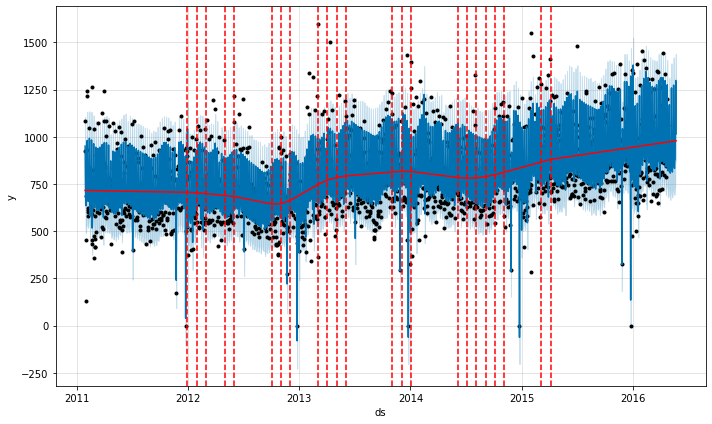

In [247]:
future = best_prophet.make_future_dataframe(periods=28)
forecast = best_prophet.predict(future)
fig3 = best_prophet.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), best_prophet, forecast)

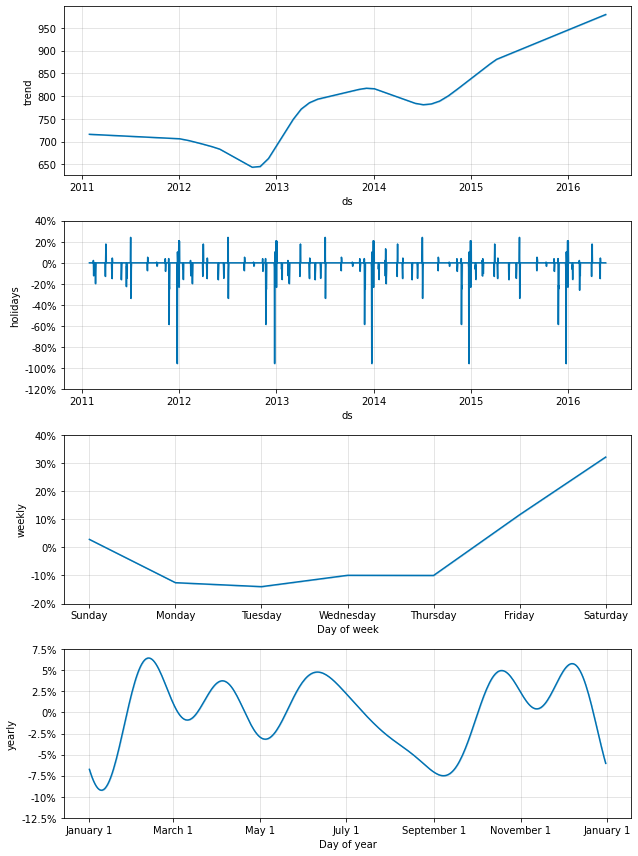

In [167]:
best_prophet.plot_components(forecast)

Попробуем добавить новый предиктор. У нас есть SNAP - индикатор участия магазина в программе льготной покупки продуктов (вряд ли поможет с HOBBIES, но все-таки попробуем):

In [171]:
# Для этого используйте файл calendar.csv и выберите колонку snap_CA. 
calendar = pd.read_csv('calendar.csv', parse_dates = ['date'])
calendar['date'] = calendar.date.dt.date
calendar = calendar[['date', 'd', 'snap_WI']]
calendar.date = pd.to_datetime(calendar.date)

In [172]:
wi_data = wi_data.merge(calendar[['date','snap_WI']], how = 'left', left_on='ds',
                                                      right_on = 'date')

In [173]:
m_custom2 = fp.Prophet(
                                    changepoint_prior_scale = 0.2,
                                    n_changepoints = 50,
                                    seasonality_mode = 'multiplicative',
                                    yearly_seasonality = 7,
                                    weekly_seasonality = 3,
                                    holidays = holiday_df,
                                    holidays_prior_scale = 5
                                )
m_custom2.add_regressor('snap_WI', mode='multiplicative')
m_custom2.fit(wi_data)
metrics = perf_metrics_28d(m_custom2)
print(f"smape={round(metrics.at[0,'smape']*100,1)}%, "
                                  f"mdape={round(metrics.at[0,'mdape']*100,1)}%, "
                                  f"coverage={round(metrics.at[0,'coverage']*100,1)}%, params={params}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000218CBDDCE88>
INFO:prophet:Skipping MAPE because y close to 0


smape=12.2%, mdape=8.9%, coverage=77.7%, params=[0.2, 80, 1, 12, 5, 1, 10]


Видим, что заметных улучшений новый предиктор нам не дал, но в то же время из-за него мы стали ограничены в своих прогнозах (не сможем ничего предсказать за пределами информации о SNAP) => оставим прежнюю модель. 

#### - А что если попробовать воспользоваться моделями другого класса? Давайте воспользуемся моделями класса [SARIMAX](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html). Это обобщение класса SARIMA. Использование внешних регрессоров не обязательно.
- Является временной ряд, с которым вы работаете стационарным? Тренд стационарым? Стационарным в разностях?
- Сколько лагов стоит использовать?

In [2]:
import scipy as sp

import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


import scipy as sp
import seaborn as sns

# Модельки
from statsmodels.tsa.arima.model import ARIMA
# Тесты
from statsmodels.tsa.stattools import adfuller, kpss, acf

pd.set_option('display.max_columns', None) # Чтобы показывались все колонки
%matplotlib inline

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput, '\n Null Hypothesis: The series has a unit root.')
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output, '\n Null Hypothesis: The process is trend stationary.')

Проверим ряд на стационарность:

Figure(432x288)
Figure(432x288)


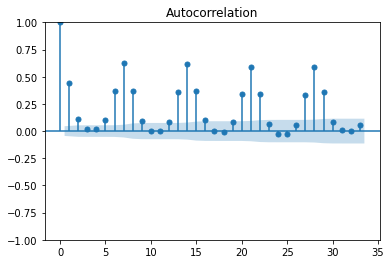

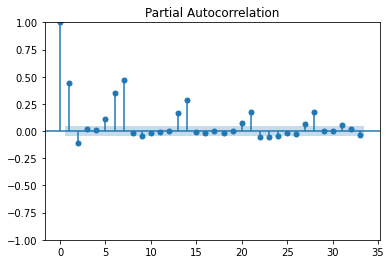

In [185]:
print(plot_acf(wi_data.y))
print(plot_pacf(wi_data.y))

Видим "пики", характерные для недельной сезональности. 
Убедимся в этом при помощи стат. тестов:

In [186]:
adf_test(wi_data.y)

Results of Dickey-Fuller Test:
Test Statistic                   -3.021206
p-value                           0.032961
#Lags Used                       26.000000
Number of Observations Used    1886.000000
Critical Value (1%)              -3.433822
Critical Value (5%)              -2.863074
Critical Value (10%)             -2.567586
dtype: float64 
 Null Hypothesis: The series has a unit root.


Таким образом, не отвергаем нулевую гипотезу о том, что ряд нестационарен => ряд нестационарен, выявлена сезональность.  

In [187]:
kpss_test(wi_data.y)

Results of KPSS Test:
Test Statistic            8.153917
p-value                   0.010000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64 
 Null Hypothesis: The process is trend stationary.


C:\Users\TEMP\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2012: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Таким образом, отвергаем нулевую гипотезу о стационарности => наш временной ряд нестационарен из-за влияния тренда.  

Теперь проверим является ли наш ряд стационарным в разностях:

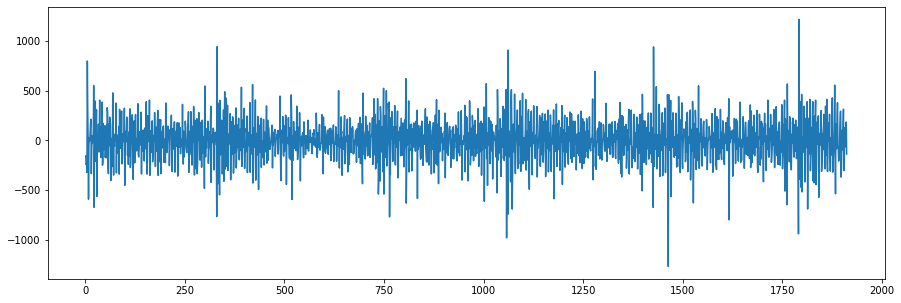

In [189]:
data_diff = wi_data.y.diff().dropna()
data_diff.plot(figsize = (15, 5));

Судя по картинке, ряд стал более похож на стационарный, но это надо проверить:

Figure(432x288)
Figure(432x288)


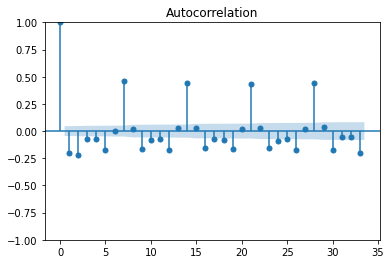

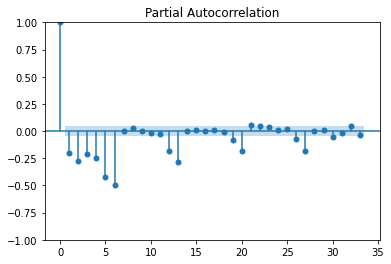

In [191]:
print(plot_acf(data_diff))
print(plot_pacf(data_diff))

Видим, что остались только пики недельной сезонности.
Посмотрим, что скажут стат. тесты:

In [194]:
adf_test(data_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.407652e+01
p-value                        2.878376e-26
#Lags Used                     2.600000e+01
Number of Observations Used    1.885000e+03
Critical Value (1%)           -3.433824e+00
Critical Value (5%)           -2.863075e+00
Critical Value (10%)          -2.567587e+00
dtype: float64 
 Null Hypothesis: The series has a unit root.


Теперь мы отвергаем нулевую гипотезу о нестационарности, вызванной сезональностью => наш ряд сезонольно стационарен в разностях.

In [195]:
kpss_test(data_diff)

Results of KPSS Test:
Test Statistic            0.046148
p-value                   0.100000
Lags Used                58.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64 
 Null Hypothesis: The process is trend stationary.


C:\Users\TEMP\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2016: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Теперь мы не отвергаем гипотезу о стационарности => наш ряд является тренд-стационарным в разностях  
Таким образом, наш ряд стационарен в разностях.

Подберем наилучшую конфигурацию SARIMA (выделим недельную сезональность):

In [245]:
%%time

best_arima = ARIMA(wi_data.y, order=(1, 1, 1), seasonal_order=(9, 0, 0, 7))
best_arima = best_arima.fit()
best_arima.summary()

Wall time: 7min 13s


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                 1913
Model:             ARIMA(1, 1, 1)x(9, 0, [], 7)   Log Likelihood              -12025.948
Date:                          Wed, 05 Oct 2022   AIC                          24075.895
Time:                                  15:53:49   BIC                          24142.566
Sample:                                       0   HQIC                         24100.431
                                         - 1913                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2236      0.016     14.287      0.000       0.193       0.254
ma.L1         -0.9991      0.001   -781.746      0.000      -1.002      -0.997
ar.S.L7        0.1804      0.021      8.748      0.000       0.140       0.221
ar.S.L14       0.1375      0.022      6.328      0.000       0.095       0.180
ar.S.L21       0.0962      0.024      4.066      0.000       0.050       0.143
ar.S.L28       0.1210      0.020      5.963      0.000       0.081       0.161
ar.S.L35       0.0237      0.022      1.082      0.279      -0.019       0.067
ar.S.L42       0.0801      0.025      3.180      0.001       0.031       0.129
ar.S.L49       0.0819      0.023      3.600      0.000       0.037       0.126
ar.S.L56       0.0781      0.023      3.355      0.001       0.032       0.124
ar.S.L63       0.1167      0.023      5.069      0.000       0.072       0.162
sigma2      1.691e+04    323.696     52.255      0.000    1.63e+04    1.75e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              2337.16
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

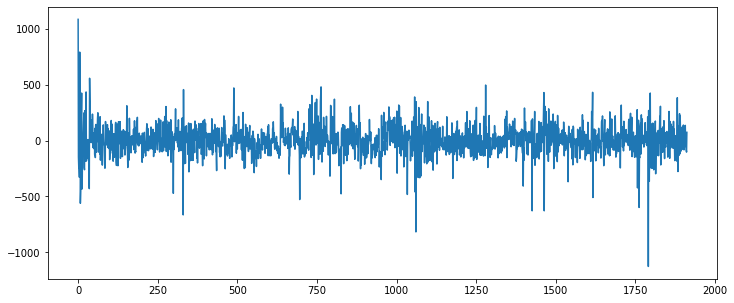

In [241]:
fig = plt.figure(figsize=(12, 5))
ax = best_arima.resid.plot()

Figure(432x288)
Figure(432x288)


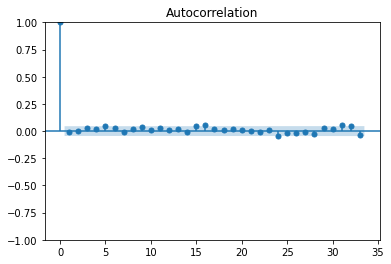

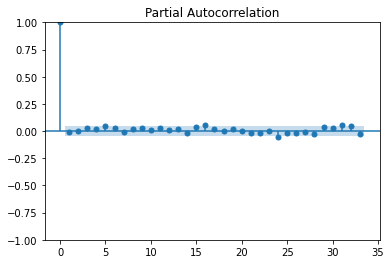

In [248]:
print(plot_acf(best_arima.resid))
print(plot_pacf(best_arima.resid))

In [249]:
acorr_ljungbox(best_arima.resid, return_df=True)

lb_stat  lb_pvalue
1    0.054797   0.814918
2    0.063705   0.968649
3    1.489278   0.684747
4    2.238660   0.691958
5    6.497418   0.260779
6    7.876956   0.247257
7    7.908833   0.340702
8    8.529343   0.383540
9   10.753611   0.292977
10  11.147776   0.346121

Видим, что остатки распределены независимо => мы хорошо обучили нашу SARIMA.

- А теперь давайте сравним предсказания моделей двух классов.
- Каким тестом воспользуетесь?
- Какие у данного теста есть ограничения?
- Какую модель в итоге будете использовать?

Для сравнения наших моделей поспользуемся **тестом Diebold-Mariano**.  
Ограничения данного теста:
- сравниваемые модели не должны быть вложенными друг в друга (этого не происходит, так как сравниваем модели разной природы).
- сравниваемые модели должны быть линейными (SARIMA - линейная модель, а вот в Prophet мы используем мультипликативный учет созональности, что, вообще говоря, является нарушением для данного теста).

In [252]:
future = best_prophet.make_future_dataframe(periods=50)
forecast = best_prophet.predict(future)
forecast_chosen = forecast[['ds','yhat']]
forecast_chosen = forecast_chosen[forecast_chosen.ds<=datetime.datetime(2016,4,24)]
forecast_test_chosen = forecast[forecast.ds>datetime.datetime(2016,4,24)][['ds','yhat']]

resid_prophet = (wi_data.y-forecast_chosen.yhat).dropna()
resid_sarima = best_arima.resid

dt = ((resid_prophet)**2-(resid_sarima)**2)

In [256]:
resid_prophet.mean(), resid_sarima.mean()

(0.03996964696764259, 4.9983925925858115)

Видим, что средняя ошибка у **Prophet** меньше, чем у SARIMA  
Проверим стат. значимость этого результата с помощью теста Diebold-Mariano:

In [254]:
from scipy import stats
stats.ttest_1samp(dt, popmean=0, alternative='less')

Ttest_1sampResult(statistic=-5.040122606230672, pvalue=2.545579273585775e-07)

Отвергаем гипотезу о равенстве средних ошибок => **Prophet** в среднем ошибается меньше (и это стат. значимо)

Таким образом, в итоге лучше ипользовать **Prophet**.

**Опционально**
- Можете посмотреть также на [Model Confidence Set](http://www.econ.upf.edu/~lugosi/hansen.pdf) (в [R](https://deliverypdf.ssrn.com/delivery.php?ID=721006122086126029008122096102104025121057026076017028009004070073075030011117018067003018063048018122018101098004022095096104106042011054015086010014019009066093071037037090073072109011022065022092067068097122090073100031093118107026068100105029083&EXT=pdf&INDEX=TRUE)) 
- Какое-то подобие на [Python](https://michael-gong.com/blogs/model-confidence-set/)

## №2.2 (60 баллов)

- Вы молодой, энергичный трейдер

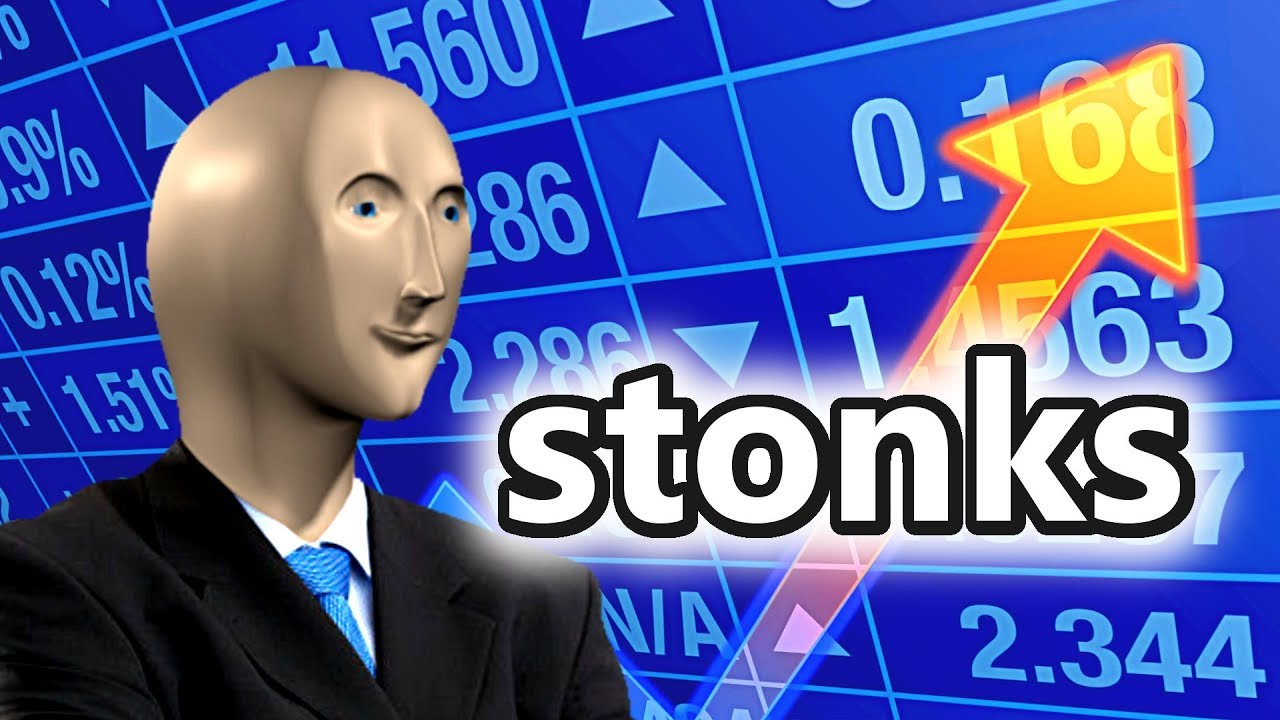

- Вы хотите применить свои знания моделей временных рядов для предсказания движения цен акций
- Для этого вы используете библиотеку `yfinance` (советую устанавливать с помощью `pip`, а не `conda install`), чтобы скачать котировки акций
- Вы должны выбрать одну акцию, которая есть в этом источнике и которая вам нравится
- После этого вы должны сделать все то же, самое, что делали в прошлом пункте - выбрать лучше модель, которая описывает данные
- Надеюсь, вы помните, что я говорил про цены и доходности, на занятии
- Однако вас волнует больше всего предсказательная способность модели, а не то, насколько хорошо она описывает данные
- В качестве аналога кросс валидации для моделей временных рядов используется бэктестирование с помощью скользящего или расширяющегося окна:
    1. Фиттим модель за период $\{0 ... t\} \rightarrow \text{ делаем предсказание } \hat{r}_{t+1}$
    2. Если скользящее окно, то фиттим модель за период $\{1 ... t+1\} \rightarrow \text{ делаем предсказание } \hat{r}_{t+2}$
       Если расширяющееся окно, то фиттим модель за период $\{0 ... t+1\} \rightarrow \text{ делаем предсказание } \hat{r}_{t+2}$
    3. Делаем так столько раз, сколько считаем нужным. Обычно, в качестве out-of-sample выборки берется 20%-30% от выборки
    4. Например, у нас 1000 наблюдений. Считаем, что 30% наблюдений пойдут для out-of-sample предсказаний. Тогда:
        - На шаге 1 мы фиттим модель на 1-700 наблюдениях и делаем предсказание для 701 наблюдения
        - На шаге 2 (предположим, что у нас скользящее окно) мы фиттим модель на 2-701 наблюдениях и делаем предсказание для 702 наблюдения
        - Последним является предсказание для 1000-го наблюдения 
        - В итоге, имеем вектор предсказаний для 701-1000 наблюдений и их фактические значения, т.е. можем посчитать те или иные метрики качества (MSE, MAE, RMSE и т.п.)
        - Выбираем модель, у которой будет наилучшая метрика качества
- Однако, это не все. Наша цель использовать эту наилучшую модель для того, чтобы обыгрывать фондовый рынок. 
    - Например,
        - $t=0, P_0 = 100$
        - $t=1, P_1 = 110 \rightarrow r_1 = 0.1, \hat{r}_2 = 0.2 \rightarrow \text{ вы покупаете акцию и стоимость вашего портфеля } V = 110 \text{ равна цене акции}$
        - $t=2, P_2 = 105, r_2 = -0.045, \text{ т.е. вы ошиблись, и стоимость вашего портфеля упала} V = 105 \text{ вы продолжаете использовать модель и делаете новое предсказание } \hat{r}_3 = -0.01 \text{ предсказание получилось отрицательным. Что вы будете делать? Продадите акцию?}$
- Дам вам возможность шортить акции бесплатно. Почитать, что это такое, можно [тут](https://place.moex.com/useful/short-i-long-na-fondovom-rynke). Однако шорт - не обязателен, будет нормально, если вы будете просто продавать акцию и держать наличные деньги в портфеле.
- Собственно, вы должны подумать, как лучше использовать предсказания, чтобы по окончанию out-of-sample периода у вас был портфель с наибольшей стоимостью. Не забудь сравнить результат этой стратегии со стратегией, когда вы покупаете акцию в самый первый момент времени и держите ее до конца (buy & hold).
- Можете почитать [эту](https://www.quantstart.com/articles/ARIMA-GARCH-Trading-Strategy-on-the-SP500-Stock-Market-Index-Using-R/) статью в качестве пример (внимание! Там `R`)

- Результаты вашей работы потом будут показы CIO (Chef Investment Officer), который даст или не даст свое разрешение на распределение капитала на вашу модель+торговую стратегию
- CIO не хочет тратить много времени ~т.к. его очередь кидать карликов в мишень~, т.к. у него много других крупных задач и проектов, поэтому:
    - Ваша стратегия должна быть простой и понятной
    - Ваш выбор модели должен быть понятным и хорошо аргументированным
    - Ваша работа должна быть воспроизводима

- Ну, что же, давайте попробуем побыть [квантами](https://habr.com/ru/company/iticapital/blog/389979/)

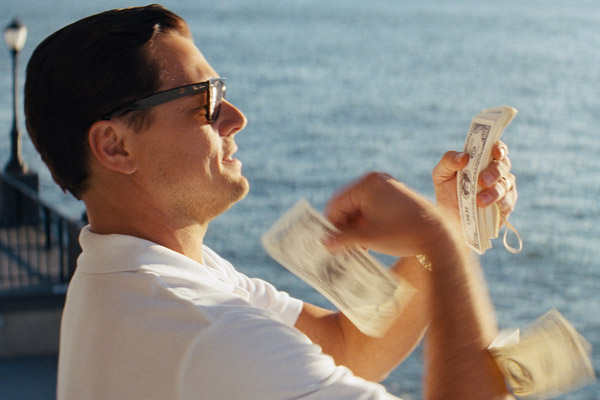

## №3 (20 баллов)*

- Это задание со звездочкой
- Баллы за это задание идут как дополнительные баллы
- Общий балл за это домашнее задание не может превышать 100 баллов
- Например, если за предыдущие 2 задания было набрано 100 баллов и за это задание набрано 20 баллов, то итоговый балл будет 100 баллов. Если же за предыдущие 2 задания было набрано 90 баллов и за это задание набрано 20 баллов, то итоговый балл все равно будет 100 баллов

- В самом первом домашнем задании вы рассмотрели такой метод как Difference in Difference (DiD)
- Давайте посмотрим внимательнее на него, а также на CUPED (у вас он был на других курсах), и на SARIMAX

In [3]:
df = pd.read_csv('HW_003_002.csv')

In [4]:
df.tail()

i  ad_campaign  revenue0   revenue1
95   96            0  3.103639   5.370367
96   97            1  4.353083  10.189088
97   98            1  5.901487  12.444846
98   99            0  7.528326  11.287131
99  100            1  4.751365  10.636274

- У нас с вами есть информация по 100 пользователям.
- `revenue0` - выручка до начала эксперимента
- `revenue1` - выручка после начала эксперимента
- `ad_campaign` - был ли пользователь в целевой группе

In [5]:
# Попробуйте воспользоваться методом DiD, который вы использовали в первой ДЗ
# Для начала вам стоит вспомнить, как выглядели данные в той первой ДЗ. Рекомендую почитать про pd.wide_to_long()
df_ = pd.wide_to_long(df, stubnames='revenue', i='i', j='is_after')
df_.reset_index(inplace=True , level=['is_after'])
df_.reset_index(inplace=True , level=['i'])
df_.head()

i  is_after  ad_campaign   revenue
0  1         0            0  5.315635
1  2         0            1  2.977799
2  3         0            0  4.693796
3  4         0            0  5.827975
4  5         0            0  5.230095

In [6]:
# Давайте попробуем зафиттить простую DiD модельку
df_['is_after_and_ad_campaign'] = df_['is_after']*df_['ad_campaign']
df_.head()

i  is_after  ad_campaign   revenue  is_after_and_ad_campaign
0  1         0            0  5.315635                         0
1  2         0            1  2.977799                         0
2  3         0            0  4.693796                         0
3  4         0            0  5.827975                         0
4  5         0            0  5.230095                         0

In [7]:
df_.groupby(['is_after', 'ad_campaign']).mean()

i    revenue  is_after_and_ad_campaign
is_after ad_campaign                                                
0        0            46.019608   5.148054                       0.0
         1            55.163265   5.017065                       0.0
1        0            46.019608   8.299482                       0.0
         1            55.163265  10.090912                       1.0

In [8]:
model = smf.ols('revenue ~ is_after + ad_campaign + is_after_and_ad_campaign', data=df_).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     198.6
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           3.74e-59
Time:                        11:21:28   Log-Likelihood:                -325.07
No. Observations:                 200   AIC:                             658.1
Df Residuals:                     196   BIC:                             671.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.1481      0.174     29.608      0.000       4.805       5.491
is_after                     3.1514      0.246     12.816      0.000       2.666       3.636
ad_campaign                 -0.1310      0.248     -0.527      0.599      -0.621       0.359
is_after_and_ad_campaign     1.9224      0.351      5.473      0.000       1.230       2.615
==============================================================================
Omnibus:                        2.651   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.266   Jarque-Bera (JB):                2.674
Skew:                           0.062   Prob(JB):                        0.263
Kurtosis:                       3.553   Cond. No.                         6.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Когда вы используется стандартную линейную регрессию из statsmodels у вас предполагается, что наблюдения независимы
- Но мы с вами знаем, что в данном случае у вас для индивидума i есть два наблюдения: до и после эксперимента
- Логично попробовать кластеризовать их по i, чтобы уменьшить дисперсию
- Почитайте про кластеризацию вариационно-ковариационной матрицы с помощью [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.get_robustcov_results.html)
- Что можете сказать про стандартные ошибки оценок коэффициентов?

In [9]:
model = smf.ols('revenue ~ is_after + ad_campaign + is_after_and_ad_campaign', data=df_).fit()
model.get_robustcov_results(cov_type='cluster', groups=np.asarray(df_["i"])).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     517.7
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           2.41e-60
Time:                        11:21:29   Log-Likelihood:                -325.07
No. Observations:                 200   AIC:                             658.1
Df Residuals:                     196   BIC:                             671.3
Df Model:                           3                                         
Covariance Type:              cluster                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.1481      0.139     37.056      0.000       4.872       5.424
is_after                     3.1514      0.128     24.707      0.000       2.898       3.405
ad_campaign                 -0.1310      0.181     -0.724      0.471      -0.490       0.228
is_after_and_ad_campaign     1.9224      0.209      9.208      0.000       1.508       2.337
==============================================================================
Omnibus:                        2.651   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.266   Jarque-Bera (JB):                2.674
Skew:                           0.062   Prob(JB):                        0.263
Kurtosis:                       3.553   Cond. No.                         6.79
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

- Чем равен эффект? Значим ли он?

Эффект равен значению коэффициента при **is_after_and_ad_campaign** (1.9224) и он стат. значим. => пронаблюдали положительный результат эксперимента.   
Стандратные ошибки уменьшились по сравнению с моделью без кластеризации (хотя и там нужный нам коэффицинт был стат. значим).

In [10]:
# А теперь попробуйте воспользоваться CUPED
df['pre_revenue_average']=df.revenue0.mean() 
theta = np.cov(df.revenue1, df.revenue0, ddof=1)[1,0]/np.var(df.revenue0, ddof=1)
corr = np.corrcoef(df.revenue1, df.revenue0)[1,0] 
df['cuped_revenue'] = df.revenue1 - theta * (df.revenue0 - df.pre_revenue_average)
df.head()

i  ad_campaign  revenue0  revenue1  pre_revenue_average  cuped_revenue
0  1            0  5.315635  8.359304             5.083869       8.093744
1  2            1  2.977799  7.751485             5.083869      10.164644
2  3            0  4.693796  9.025253             5.083869       9.472203
3  4            0  5.827975  8.540667             5.083869       7.688063
4  5            0  5.230095  8.910165             5.083869       8.742618

In [11]:
df.groupby('ad_campaign').mean()

i  revenue0   revenue1  pre_revenue_average  \
ad_campaign                                                        
0            46.019608  5.148054   8.299482             5.083869   
1            55.163265  5.017065  10.090912             5.083869   

             cuped_revenue  
ad_campaign                 
0                 8.225938  
1                10.167458

In [12]:
# рассчитаем эффект по cuped-метрике
10.167458 - 8.225938

1.9415200000000006

In [13]:
# проверим его стат. значимость с помощью t-теста
from scipy import stats
stats.ttest_ind(df[(df.ad_campaign==1)].cuped_revenue, df[df.ad_campaign==0].cuped_revenue, equal_var=False)

Ttest_indResult(statistic=9.48144844707255, pvalue=3.254228064471603e-15)

- Что у вас получилось?
- Отличается ли это от того, что у вас получилось ранее?

Таким образом, получили очень похожий результат (размер эффекта около 1.9 и он стат. значим).

- Прежде чем вы продолжите, давайте я немного расскажу про все эти замечательные классы моделей SARIMAX
- Вы уже знаете общую теорию про SARIMA. В целом, этого вам достаточно. Буква `X` означает, что это модель с внешними регрессорами (eXternal regressors). 
- В качестве внешних регрессоров может быть все, что угодно
- Поэтому, когда вы видите, какую нибудь MA-X модель (хотя я сомневаюсь, что кто-то такое использует), это просто означает простую MA модель с внешними регрессорами

In [106]:
# А теперь попробуйте зафиттить AR-X модель. Я напомню, что revenue1 это значение после эксперимента, а revenue0 - до него

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(endog=df_.revenue, exog=df_.is_after_and_ad_campaign, order=(1, 1, 1))
sarimax = sarimax.fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                revenue   No. Observations:                  200
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -341.550
Date:                Fri, 07 Oct 2022   AIC                            691.099
Time:                        13:31:28   BIC                            704.273
Sample:                             0   HQIC                           696.431
                                - 200                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
is_after_and_ad_campaign     1.9258      0.235      8.209      0.000       1.466       2.386
ar.L1                       -0.1166      0.079     -1.476      0.140      -0.272       0.038
ma.L1                       -0.7997      0.045    -17.800      0.000      -0.888      -0.712
sigma2                       1.8016      0.172     10.497      0.000       1.465       2.138
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 2.96
Prob(Q):                              0.82   Prob(JB):                         0.23
Heteroskedasticity (H):               3.58   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Что у вас получилось?
- Отличается ли это от того, что у вас получилось ранее?

Видим, что кожффициент также около 0.9, так что снова получили похожие результаты.

- Небольшой спойлер. У вас должны были получиться более менее одинаковые коэффициенты
- А давайте посмотрим с новым набором данных

In [71]:
df_new = pd.read_csv('HW_003_003.csv')

In [72]:
df_new.head()

i  ad_campaign  revenue0  revenue1
0  1            0  5.315635  8.359304
1  2            1  3.977799  8.751485
2  3            0  4.693796  9.025253
3  4            0  5.827975  8.540667
4  5            0  5.230095  8.910165

- Проделайте все то же самое, что и ранее
- Что изменилось?
- В чем разница между старыми данными и этими?

1. Метод DiD без кластеризации: 

In [77]:
# Попробуйте воспользоваться методом DiD, который вы использовали в первой ДЗ
# Для начала вам стоит вспомнить, как выглядели данные в той первой ДЗ. Рекомендую почитать про pd.wide_to_long()
df_new_ = pd.wide_to_long(df_new, stubnames='revenue', i='i', j='is_after')
df_new_.reset_index(inplace=True , level=['is_after'])
df_new_.reset_index(inplace=True , level=['i'])
df_new_.head()

i  is_after  ad_campaign   revenue
0  1         0            0  5.315635
1  2         0            1  3.977799
2  3         0            0  4.693796
3  4         0            0  5.827975
4  5         0            0  5.230095

In [78]:
df_new_['is_after_and_ad_campaign'] = df_new_['is_after']*df_new_['ad_campaign']
df_new_.head()

i  is_after  ad_campaign   revenue  is_after_and_ad_campaign
0  1         0            0  5.315635                         0
1  2         0            1  3.977799                         0
2  3         0            0  4.693796                         0
3  4         0            0  5.827975                         0
4  5         0            0  5.230095                         0

In [79]:
df_new_.groupby(['is_after', 'ad_campaign']).mean()

i    revenue  is_after_and_ad_campaign
is_after ad_campaign                                                
0        0            46.019608   5.148054                       0.0
         1            55.163265   6.017065                       0.0
1        0            46.019608   8.299482                       0.0
         1            55.163265  11.090912                       1.0

In [80]:
model_new = smf.ols('revenue ~ is_after + ad_campaign + is_after_and_ad_campaign', data=df_new_).fit()
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     227.3
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           1.51e-63
Time:                        12:01:11   Log-Likelihood:                -325.07
No. Observations:                 200   AIC:                             658.1
Df Residuals:                     196   BIC:                             671.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.1481      0.174     29.608      0.000       4.805       5.491
is_after                     3.1514      0.246     12.816      0.000       2.666       3.636
ad_campaign                  0.8690      0.248      3.499      0.001       0.379       1.359
is_after_and_ad_campaign     1.9224      0.351      5.473      0.000       1.230       2.615
==============================================================================
Omnibus:                        2.651   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.266   Jarque-Bera (JB):                2.674
Skew:                           0.062   Prob(JB):                        0.263
Kurtosis:                       3.553   Cond. No.                         6.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Снова получили эффект, похожий на 1.9
2. Метод DiD с кластеризацией:

In [81]:
model_new = smf.ols('revenue ~ is_after + ad_campaign + is_after_and_ad_campaign', data=df_new_).fit()
model_new.get_robustcov_results(cov_type='cluster', groups=np.asarray(df_["i"])).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     530.5
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           7.69e-61
Time:                        12:01:54   Log-Likelihood:                -325.07
No. Observations:                 200   AIC:                             658.1
Df Residuals:                     196   BIC:                             671.3
Df Model:                           3                                         
Covariance Type:              cluster                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.1481      0.139     37.056      0.000       4.872       5.424
is_after                     3.1514      0.128     24.707      0.000       2.898       3.405
ad_campaign                  0.8690      0.181      4.803      0.000       0.510       1.228
is_after_and_ad_campaign     1.9224      0.209      9.208      0.000       1.508       2.337
==============================================================================
Omnibus:                        2.651   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.266   Jarque-Bera (JB):                2.674
Skew:                           0.062   Prob(JB):                        0.263
Kurtosis:                       3.553   Cond. No.                         6.79
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

И снова похожий на 1.9 эффект.
3. CUPED:

In [82]:
# А теперь попробуйте воспользоваться CUPED
df_new['pre_revenue_average']=df_new.revenue0.mean() 
theta = np.cov(df_new.revenue1, df_new.revenue0, ddof=1)[1,0]/np.var(df_new.revenue0, ddof=1)
corr = np.corrcoef(df_new.revenue1, df_new.revenue0)[1,0] 
df_new['cuped_revenue'] = df_new.revenue1 - theta * (df_new.revenue0 - df_new.pre_revenue_average)
df_new.head()

i  ad_campaign  revenue0  revenue1  pre_revenue_average  cuped_revenue
0  1            0  5.315635  8.359304             5.573869       8.773156
1  2            1  3.977799  8.751485             5.573869      11.309382
2  3            0  4.693796  9.025253             5.573869      10.435678
3  4            0  5.827975  8.540667             5.573869       8.133432
4  5            0  5.230095  8.910165             5.573869       9.461105

In [83]:
df_new.groupby('ad_campaign').mean()

i  revenue0   revenue1  pre_revenue_average  \
ad_campaign                                                        
0            46.019608  5.148054   8.299482             5.573869   
1            55.163265  6.017065  11.090912             5.573869   

             cuped_revenue  
ad_campaign                 
0                 8.981903  
1                10.380638

In [85]:
# рассчитаем эффект по cuped-метрике
10.380638 - 8.981903

1.3987349999999985

In [84]:
# проверим его стат. значимость с помощью t-теста
from scipy import stats
stats.ttest_ind(df_new[(df_new.ad_campaign==1)].cuped_revenue, df_new[df_new.ad_campaign==0].cuped_revenue, equal_var=False)

Ttest_indResult(statistic=6.4957816030555, pvalue=4.069522096258675e-09)

А вот CUPED уже дал гораздо меньший эффект pvalue значительно повысилось, хоть и осталось меньше адекватных уровней значимости.
4. SARIMAX:

In [107]:
sarimax = SARIMAX(endog=df_new_.revenue, exog=df_new_.is_after_and_ad_campaign, order=(1, 1, 1))
sarimax = sarimax.fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                revenue   No. Observations:                  200
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -344.124
Date:                Fri, 07 Oct 2022   AIC                            696.247
Time:                        13:32:01   BIC                            709.420
Sample:                             0   HQIC                           701.579
                                - 200                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
is_after_and_ad_campaign     2.9139      0.243     12.013      0.000       2.439       3.389
ar.L1                       -0.1085      0.078     -1.398      0.162      -0.261       0.044
ma.L1                       -0.8352      0.043    -19.354      0.000      -0.920      -0.751
sigma2                       1.8473      0.189      9.775      0.000       1.477       2.218
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.20
Prob(Q):                              0.77   Prob(JB):                         0.55
Heteroskedasticity (H):               3.08   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Видим, что коэфффициент при **is_after_and_ad_campaign** значительно возрос.

**Отличия в данных**  
Посмотрим сначала на описательные статистики:

In [109]:
df.describe()

i  ad_campaign    revenue0    revenue1  pre_revenue_average  \
count  100.000000   100.000000  100.000000  100.000000         1.000000e+02   
mean    50.500000     0.490000    5.083869    9.177283         5.083869e+00   
std     29.011492     0.502418    0.903621    1.746547         8.033876e-15   
min      1.000000     0.000000    2.565162    4.922274         5.083869e+00   
25%     25.750000     0.000000    4.648289    8.255284         5.083869e+00   
50%     50.500000     0.000000    5.129761    9.053565         5.083869e+00   
75%     75.250000     1.000000    5.634423   10.385412         5.083869e+00   
max    100.000000     1.000000    7.528326   14.124508         5.083869e+00   

       cuped_revenue  
count     100.000000  
mean        9.177283  
std         1.406562  
min         6.304982  
25%         8.206608  
50%         8.926838  
75%        10.082769  
max        12.365221

In [110]:
df_new.describe()

i  ad_campaign    revenue0    revenue1  pre_revenue_average  \
count  100.000000   100.000000  100.000000  100.000000         1.000000e+02   
mean    50.500000     0.490000    5.573869    9.667283         5.573869e+00   
std     29.011492     0.502418    1.001412    2.051159         8.033876e-15   
min      1.000000     0.000000    2.565162    4.922274         5.573869e+00   
25%     25.750000     0.000000    4.941215    8.461690         5.573869e+00   
50%     50.500000     0.000000    5.742573    9.584313         5.573869e+00   
75%     75.250000     1.000000    6.255038   11.090114         5.573869e+00   
max    100.000000     1.000000    8.186980   15.124508         5.573869e+00   

       cuped_revenue  
count     100.000000  
mean        9.667283  
std         1.277340  
min         6.762281  
25%         8.787319  
50%         9.543736  
75%        10.609785  
max        12.450472

Видим, что все значения кроме минимума подросли как для `revenue0`, так и для `revenue1`.  
Посмотрим, на агрегированные по тестовой группе данные:

In [112]:
df.groupby('ad_campaign').mean()

i  revenue0   revenue1  pre_revenue_average  \
ad_campaign                                                        
0            46.019608  5.148054   8.299482             5.083869   
1            55.163265  5.017065  10.090912             5.083869   

             cuped_revenue  
ad_campaign                 
0                 8.225938  
1                10.167458

In [111]:
df_new.groupby('ad_campaign').mean()

i  revenue0   revenue1  pre_revenue_average  \
ad_campaign                                                        
0            46.019608  5.148054   8.299482             5.573869   
1            55.163265  6.017065  11.090912             5.573869   

             cuped_revenue  
ad_campaign                 
0                 8.981903  
1                10.380638

Видим, что во втором случае наблюдается довольно сильное отличие на предпериоде (`revenue0`), а в первом такого отличия нет.  
Проверим стат. значимость этих отличий:

In [113]:
stats.ttest_ind(df[(df.ad_campaign==1)].revenue0, df[df.ad_campaign==0].revenue0, equal_var=False)

Ttest_indResult(statistic=-0.7258065674516202, pvalue=0.4697304163934827)

In [114]:
stats.ttest_ind(df_new[(df_new.ad_campaign==1)].revenue0, df_new[df_new.ad_campaign==0].revenue0, equal_var=False)

Ttest_indResult(statistic=4.815141328994742, pvalue=5.504946719764124e-06)

Видим, что во втором случае эти отличия стат. значимы => группы вели себя неодинаково уже до эксперимента. Скорее всего это и повредило наши коэффициенты.